## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn.metrics import r2_score
import pickle

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
sys.path.insert(1, './params')
from cper_bm_params_eval_kmeans_transect import *

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
import copy
from skorch import NeuralNetRegressor
import skorch
from dnn_setup import ResNetRegressor, ResidualBlock

## Define I/O

In [4]:
from importlib import reload
#reload(sys.modules["cper_bm_params_eval_year_transect"])
#from cper_bm_params_eval_year_plot import *

In [5]:
save_results = False
outDIR = './results'

In [6]:
def r_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    r = corr
    return r

In [7]:
mods = ['CPER_2022', 'OLS_2022', 'OLS', 
        'LASSO', 'PLS', 'PCR', 
        'SVR', 'RF', 'GBR', 'HGBR', 'DNN',
        'ENS_LIN', 'ENS_ML', 'ENS_ALL']

In [8]:
#dist_facts = list(np.arange(0, 12, 2))
#dist_facts = [10, 50, 75, 85, 95, 99, 0]
keep_fracs = [100, 99, 95, 85, 75, 50, 10, 1]

## Load and pre-process data

In [11]:
for keep_frac in keep_fracs:
    reload(sys.modules["cper_bm_params_eval_kmeans_transect"])
    from cper_bm_params_eval_kmeans_transect import *
    if keep_frac != 100:
        kfold_group = kfold_group + '_r' + str(keep_frac)
        tuneby_group = tuneby_group + '_r' + str(keep_frac)
        inPATH = os.path.join(inDIR, 'vor_2014_2023_cln_2024_04_04_' + prefix + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_tmp.csv')
    
    print('Loading results from ' + 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group)
    with open(os.path.join(inDIR, 'ml_train_' + nickname + '_cv_' + kfold_group + '_tuneby_' + tuneby_group + '_results.pk'), 'rb') as f:
        mod_dict = pickle.load(f)
    df = pd.read_csv(inPATH)
    if 'transect' in inPATH:
        df['Plot'] = df[id_col].transform(lambda x: '_'.join(x.split('_')[:-1]))
    elif 'plot' in inPATH:
        df['Plot'] = df[id_col]
    
    keep_cols = var_names + id_cols + [logo_group, y_col, date_col, past_col, id_col] + group_cols + list(mod_dict.keys())
    
    drop_cols = [x for x in df.columns if x not in keep_cols]
    
    df_bm_pred = pd.melt(df.drop(columns=drop_cols + var_names).rename(columns={y_col: 'Observed'}), 
                     id_vars=id_cols + [logo_group], 
                     value_name='Predicted',
                     var_name='Source')
    
    df_ens_lin = df_bm_pred[df_bm_pred['Source'].isin(
        ['LASSO', 'PLS', 'PCR'])].drop(columns=['Source']).groupby(
        [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
    df_ens_lin['Source'] = 'ENS_LIN'
    
    df_ens_ml = df_bm_pred[df_bm_pred['Source'].isin(
        ['SVR', 'RF', 'GBR', 'HGBR'])].drop(columns=['Source']).groupby(
        [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
    df_ens_ml['Source'] = 'ENS_ML'
    
    df_ens_both = df_bm_pred[df_bm_pred['Source'].isin(
        ['LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'GBR', 'HGBR'])].drop(columns=['Source']).groupby(
        [x for x in df_bm_pred.columns if x not in ['Source', 'Predicted']]).mean().reset_index()
    df_ens_both['Source'] = 'ENS_ALL'
    
    df_bm_pred = pd.concat([df_bm_pred, df_ens_lin, df_ens_ml, df_ens_both])
    
    for k in df_bm_pred['Source'].unique():
        if k in mod_dict.keys():
            if mod_dict[k]['xfrm_y'] is not None:
                df_bm_pred.loc[df_bm_pred['Source'] == k, 
                'Observed_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
                df_bm_pred.loc[df_bm_pred['Source'] == k, 
                'Predicted_xfrm'] = mod_dict[k]['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])
        else:
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Observed_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Observed'])
            df_bm_pred.loc[df_bm_pred['Source'] == k, 
            'Predicted_xfrm'] = mod_dict['PLS']['xfrm_y'](df_bm_pred.loc[df_bm_pred['Source'] == k, 'Predicted'])
    
    df_bm_pred['Source'] = pd.Categorical(df_bm_pred['Source'], 
                                          categories=mods)
    
    df_bm_pred['Source'] = df_bm_pred['Source'].cat.remove_unused_categories()

    max_lim = max(df_bm_pred[['Observed', 'Predicted']].max())*1.1
    max_lim_xfrm = max(df_bm_pred[['Observed_xfrm', 'Predicted_xfrm']].max())*1.1
    
    if 'transect' in inPATH:
        mae_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
            lambda z: z.groupby([id_col, date_col]).apply(
                lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
                include_groups=False).mean(), include_groups=False).round(4)
        bias_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
            lambda z: z.groupby([id_col, date_col]).apply(
                lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
                include_groups=False).mean(), include_groups=False).round(4)
        mae_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
            lambda z: z.groupby([id_col, date_col]).apply(
                lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
                include_groups=False).mean(), include_groups=False).round(4)
        bias_bt_transect = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
            lambda z: z.groupby([id_col, date_col]).apply(
                lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
                include_groups=False).mean(), include_groups=False).round(4)
        r2_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                     observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
            [mod_col, logo_group], observed=True).apply(
            lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
            include_groups=False).round(4)
        r2_corr_transect = df_bm_pred.groupby([mod_col, logo_group, id_col, past_col, date_col], 
                                     observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
            [mod_col, logo_group], observed=True).apply(
                lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
            include_groups=False).round(4)
    
        df_smry_transect = pd.DataFrame({
            'MAE': mae_transect.unstack(level=0).mean().round(4),
            'MAE_std': mae_transect.unstack(level=0).std().round(4),
            'Bias': bias_transect.unstack(level=0).mean().round(4),
            'Bias_std': bias_transect.unstack(level=0).std().round(4),
            'R^2': r2_transect.unstack(level=0).mean().round(4),
            'R^2_std': r2_transect.unstack(level=0).std().round(4),
            'r': r2_corr_transect.unstack(level=0).mean().round(4),
            'r_std': r2_corr_transect.unstack(level=0).std().round(4),
            'MAE_bt': mae_bt_transect.unstack(level=0).mean().round(4),
            'MAE_bt_std': mae_bt_transect.unstack(level=0).std().round(4),
            'MAE_bt_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                            observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
            'MAE_bt_pct_std': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], 
                                                            observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
            'Bias_bt': bias_bt_transect.unstack(level=0).mean().round(4),
            'Bias_bt_std': bias_bt_transect.unstack(level=0).std().round(4),
        })
        display(df_smry_transect)
        if save_results:
            df_smry_transect.to_csv(os.path.join(outDIR,
                                                 'tables/ml_models', 
                                                 re.sub('tmp.csv', 'results_transect.csv', os.path.basename(inPATH))))
        
        df_smry_transect_by_yr = pd.DataFrame({
            'MAE': mae_transect.round(4),
            'Bias': bias_transect.round(4),
            'MAE_bt': mae_bt_transect.round(4),
            'MAE_pct': (mae_bt_transect / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(4),
            'R^2': r2_transect.round(4),
            'r': r2_corr_transect.round(4)
        })
        #display(df_smry_transect_by_yr)
        if save_results:
            df_smry_transect_by_yr.to_csv(os.path.join(outDIR,
                                                       'tables/ml_models', 
                                                       re.sub('tmp.csv', 'results_transect_yrly.csv', os.path.basename(inPATH))))
    
        p_transect = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, id_col, date_col], 
                                               observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
                       x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                            facet_kws=dict(sharey=False, sharex=False,),
                            hue=logo_group, ci=None,
                            scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
        for ax in p_transect.axes:
            ax.set_ylim((0, max_lim_xfrm))
            ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
        p_transect.axes[0].set_ylim((4, 11))
        p_transect.axes[0].set_xlim((4, 11))
        p_transect.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
        if save_results:
            plt.savefig(os.path.join(outDIR, 
                                     'figures/ml_models',
                                     re.sub('tmp.csv', 'results_transect.png', os.path.basename(inPATH))), dpi=100)
    
    mae_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby(['Plot', date_col]).apply(
            lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])), 
            include_groups=False).mean(), include_groups=False).round(4)
    bias_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby(['Plot', date_col]).apply(
            lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
            include_groups=False).mean(), include_groups=False).round(4)
    mae_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby(['Plot', date_col]).apply(
            lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
            include_groups=False).mean(), include_groups=False).round(4)
    bias_bt_plot = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
        lambda z: z.groupby(['Plot', date_col]).apply(
            lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
            include_groups=False).mean(), include_groups=False).round(4)
    r2_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
        lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
        include_groups=False).round(4)
    r2_corr_plot = df_bm_pred.groupby([mod_col, logo_group, 'Plot', past_col, date_col], 
                                 observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby(
        [mod_col, logo_group], observed=True).apply(
            lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
        include_groups=False).round(4)
    
    df_smry_plot = pd.DataFrame({
        'MAE': mae_plot.unstack(level=0).mean().round(4),
        'MAE_std': mae_plot.unstack(level=0).std().round(4),
        'Bias': bias_plot.unstack(level=0).mean().round(4),
        'Bias_std': bias_plot.unstack(level=0).std().round(4),
        'R^2': r2_plot.unstack(level=0).mean().round(4),
        'R^2_std': r2_plot.unstack(level=0).std().round(4),
        'r': r2_corr_plot.unstack(level=0).mean().round(4),
        'r_std': r2_corr_plot.unstack(level=0).std().round(4),
        'MAE_bt': mae_bt_plot.unstack(level=0).mean().round(4),
        'MAE_bt_std': mae_bt_plot.unstack(level=0).std().round(4),
        'MAE_bt_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
        'MAE_bt_pct_std': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], 
                                                        observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
        'Bias_bt': bias_bt_plot.unstack(level=0).mean().round(4),
        'Bias_bt_std': bias_bt_plot.unstack(level=0).std().round(4),
    })
    display(df_smry_plot)
    if save_results:
        df_smry_plot.to_csv(os.path.join(outDIR,
                                         'tables/ml_models', 
                                         re.sub('tmp.csv', 'results_plot.csv', os.path.basename(inPATH))))
    
    df_smry_plot_by_yr = pd.DataFrame({
        'MAE': mae_plot.round(4),
        'Bias': bias_plot.round(4),
        'MAE_bt': mae_bt_plot.round(4),
        'MAE_pct': (mae_bt_plot / df_bm_pred.groupby([mod_col, logo_group], observed=True)['Observed'].mean()).round(4),
        'R^2': r2_plot.round(4),
        'r': r2_corr_plot.round(4)
    })
    #display(df_smry_plot_by_yr)
    if save_results:
        df_smry_plot_by_yr.to_csv(os.path.join(outDIR, 
                                               'tables/ml_models', 
                                               re.sub('tmp.csv', 'results_plot_yrly.csv', os.path.basename(inPATH))))
    
    p_plot = sns.lmplot(df_bm_pred.groupby([mod_col, logo_group, 'Plot', date_col], 
                                           observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
                   x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                        facet_kws=dict(sharey=False, sharex=False,),
                        hue=logo_group, ci=None,
                        scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
    for ax in p_plot.axes:
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
    p_plot.axes[0].set_ylim((4, 11))
    p_plot.axes[0].set_xlim((4, 11))
    p_plot.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
    if save_results:
        plt.savefig(os.path.join(outDIR, 
                                 'figures/ml_models', 
                                 re.sub('tmp.csv', 'results_plot.png', os.path.basename(inPATH))), dpi=100)

Loading results from ml_train_cper_bm_transect_cv_Kmeans_tuneby_Kmeans


,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,0.3549,0.0476,0.0204,0.2271,0.1253,0.1469,0.5665,0.1175,301.2481,114.4921,0.3426,0.0312,-58.0003,219.2322
OLS_2022,4.7540,0.8119,-0.3952,2.6293,0.1651,0.2297,0.5770,0.0728,289.8202,106.1017,0.3313,0.0421,-56.5056,163.1043
OLS,5.2095,1.6657,0.7776,3.7569,0.0477,0.3329,0.5956,0.0782,324.2025,174.5430,0.3613,0.0861,47.7661,239.7401
LASSO,4.7203,0.6930,0.4749,2.3335,0.1825,0.2006,0.5614,0.1041,285.5300,99.5544,0.3321,0.0585,-22.2069,137.9633
PLS,4.4524,0.9962,-0.2274,1.7353,0.2950,0.0922,0.6124,0.0399,273.9874,117.3999,0.3064,0.0255,-37.4893,111.5724
PCR,4.3956,0.9756,-0.0536,1.7334,0.3066,0.0949,0.6156,0.0374,271.4979,114.4711,0.3038,0.0224,-33.8826,113.6885
SVR,4.4237,0.9146,-0.3925,1.9057,0.2943,0.0416,0.6121,0.0348,271.6863,111.6813,0.3050,0.0222,-62.9034,120.2580
RF,5.0450,1.3132,0.5298,3.2851,0.1189,0.1678,0.5541,0.0847,310.0975,141.8184,0.3486,0.0582,-6.9285,207.0114
HGBR,5.0021,1.3391,0.4783,3.0359,0.1379,0.1633,0.5412,0.1081,308.1564,144.7311,0.3453,0.0605,-9.6339,191.2617


,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,0.3088,0.0480,0.0205,0.2271,0.1204,0.2064,0.6257,0.1322,263.5469,101.7715,0.2999,0.0314,-57.8886,219.1125
OLS_2022,4.0471,0.6857,-0.3936,2.6293,0.1760,0.3276,0.6396,0.0799,247.9787,88.0778,0.2854,0.0447,-56.4107,163.1198
OLS,4.4835,1.5946,0.7806,3.7600,0.0455,0.4418,0.6672,0.0801,279.2520,155.6661,0.3130,0.0871,47.9812,240.0580
LASSO,3.9395,0.5185,0.4773,2.3347,0.2059,0.2611,0.6265,0.1148,238.3668,78.8592,0.2800,0.0577,-22.0656,137.9862
PLS,3.6465,0.8279,-0.2256,1.7362,0.3649,0.1250,0.6837,0.0404,226.6199,97.0096,0.2536,0.0225,-37.3831,111.6588
PCR,3.5880,0.8051,-0.0513,1.7351,0.3734,0.1278,0.6866,0.0368,223.8245,94.4357,0.2503,0.0195,-33.7477,113.7949
SVR,3.6372,0.7323,-0.3903,1.9073,0.3519,0.0607,0.6828,0.0330,225.9073,92.7486,0.2533,0.0179,-62.7750,120.3254
RF,4.2548,1.1943,0.5333,3.2885,0.1379,0.2258,0.6322,0.0919,262.0322,123.4046,0.2949,0.0587,-6.7179,207.2375
HGBR,4.1807,1.2074,0.4820,3.0397,0.1666,0.2187,0.6142,0.1170,258.1566,125.3396,0.2893,0.0606,-9.4016,191.5160


Loading results from ml_train_cper_bm_transect_cv_Kmeans_r99_tuneby_Kmeans_r99


,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,0.3543,0.0464,0.0197,0.2262,0.1348,0.1473,0.5753,0.0986,302.0665,113.5717,0.3416,0.0287,-58.3283,219.1237
OLS_2022,4.7428,0.8092,-0.3716,2.5851,0.1858,0.2367,0.5891,0.0657,289.6312,105.4414,0.3290,0.0404,-55.1363,160.2779
OLS,4.7596,0.7141,-0.4010,2.5635,0.1613,0.2870,0.6071,0.0762,286.5570,99.2102,0.3301,0.0569,-44.0534,143.5421
LASSO,4.6804,0.6706,0.4016,2.2312,0.2155,0.1565,0.5798,0.0634,283.6128,97.8105,0.3271,0.0510,-25.5588,133.0567
PLS,4.4565,0.9911,-0.2227,1.7179,0.3077,0.1063,0.6209,0.0471,274.4930,116.7731,0.3052,0.0242,-37.0449,109.9887
PCR,4.3993,0.9797,-0.0073,1.6665,0.3205,0.1133,0.6235,0.0409,272.1714,114.3036,0.3025,0.0206,-31.1080,110.2321
SVR,4.3951,0.9458,-0.4088,1.7625,0.3174,0.0678,0.6226,0.0380,271.0144,112.4467,0.3013,0.0160,-61.9451,113.9356
RF,5.1231,1.3517,0.3653,3.3931,0.1105,0.1757,0.5575,0.0842,316.2907,144.1745,0.3521,0.0517,-13.9691,216.8889
HGBR,4.8365,1.3461,0.6091,2.3906,0.2123,0.1419,0.5565,0.1162,299.1198,143.4033,0.3322,0.0550,1.0392,150.7322


,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,0.3082,0.0472,0.0198,0.2263,0.1320,0.2116,0.6359,0.1094,264.2308,100.7871,0.2991,0.0299,-58.2167,219.0036
OLS_2022,4.0295,0.6849,-0.3700,2.5851,0.1996,0.3397,0.6526,0.0717,247.3274,87.6299,0.2826,0.0428,-55.0414,160.2937
OLS,3.9971,0.6350,-0.3995,2.5628,0.1847,0.4074,0.6769,0.0828,240.8705,78.9054,0.2812,0.0629,-43.9520,143.5124
LASSO,3.8980,0.5042,0.4037,2.2323,0.2481,0.2129,0.6458,0.0690,236.4590,78.0795,0.2749,0.0503,-25.4356,133.0698
PLS,3.6500,0.8288,-0.2210,1.7187,0.3776,0.1461,0.6919,0.0501,227.0158,96.7232,0.2525,0.0217,-36.9395,110.0747
PCR,3.5838,0.8173,-0.0051,1.6681,0.3895,0.1518,0.6951,0.0416,223.9116,94.5731,0.2487,0.0193,-30.9736,110.3388
SVR,3.6032,0.7590,-0.4066,1.7640,0.3796,0.0903,0.6930,0.0384,224.8435,93.0000,0.2498,0.0123,-61.8155,114.0070
RF,4.3433,1.2778,0.3690,3.3967,0.1323,0.2334,0.6359,0.0871,269.1981,128.5010,0.2992,0.0551,-13.7419,217.1270
HGBR,3.9639,1.1597,0.6123,2.3937,0.2750,0.1659,0.6381,0.1136,245.5571,119.8434,0.2733,0.0518,1.2278,150.9295


Loading results from ml_train_cper_bm_transect_cv_Kmeans_r95_tuneby_Kmeans_r95


,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,0.3569,0.0431,0.0148,0.2225,0.1584,0.1921,0.5806,0.1298,297.4912,110.1342,0.3431,0.0295,-66.4105,209.4563
OLS_2022,4.6150,0.7728,-0.2539,2.1398,0.2408,0.1796,0.5920,0.0827,279.6484,102.7402,0.3231,0.0328,-46.7595,131.8781
OLS,4.4253,1.1305,0.3839,1.7619,0.3298,0.1132,0.6196,0.0738,270.3626,122.2360,0.3061,0.0391,-9.8782,109.5205
LASSO,4.2633,0.9054,-0.0911,1.2477,0.3671,0.0715,0.6350,0.0520,260.3705,107.4577,0.2962,0.0252,-41.6067,81.8797
PLS,4.3080,0.8882,-0.2591,1.2730,0.3500,0.0975,0.6351,0.0498,263.1364,107.1840,0.2992,0.0195,-42.5328,83.6319
PCR,4.3067,0.9243,-0.0022,1.3328,0.3514,0.0978,0.6319,0.0517,263.8545,108.6440,0.2995,0.0194,-32.0090,89.0251
SVR,4.3081,0.8925,-0.6812,1.3320,0.3418,0.0544,0.6229,0.0581,263.1933,106.7684,0.2991,0.0199,-76.2477,91.6371
RF,4.5415,1.3757,-0.3825,2.2627,0.3085,0.1006,0.6101,0.0707,280.3024,137.2273,0.3111,0.0457,-55.5445,145.4843
HGBR,4.4652,1.2493,-0.2651,1.8364,0.3261,0.0899,0.6044,0.0879,274.7871,130.2655,0.3078,0.0439,-50.2857,117.4607


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f092b88c0d0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f091d66c790> (for post_execute):



KeyboardInterrupt



## Check disaggregated prediction

In [ ]:
#df_bm_pred = df_bm_pred.groupby([mod_col, logo_group,  id_col, date_col] + group_cols).mean().reset_index().dropna()

In [ ]:
mae_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted_xfrm'] - x['Observed_xfrm'])), include_groups=False).round(4)
bias_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(x['Predicted_xfrm'] - x['Observed_xfrm']), include_groups=False).round(4)
mae_bt_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    lambda x: np.mean(abs(x['Predicted'] - x['Observed'])), include_groups=False).round(4)
r2_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
    (lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm'])), include_groups=False).round(4)
r2_corr_obs = df_bm_pred.groupby([mod_col], observed=True).apply(
        lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']), include_groups=False).round(4)

In [94]:
df_smry_obs = pd.DataFrame({
    'MAE': mae_obs.round(4),
    'Bias': bias_obs.round(4),
    'R^2': r2_obs.round(4),
    'r': r2_corr_obs.round(4),
    'MAE_bt': mae_bt_obs.round(4),
    'MAE_bt_pct': (mae_bt_obs / df_bm_pred[[mod_col, 'Observed']].groupby([mod_col], observed=True).mean()['Observed']).round(4),
})
display(df_smry_obs)

,MAE,Bias,R^2,r,MAE_bt,MAE_bt_pct
Source,,,,,,
CPER_2022,0.3563,0.0274,0.4957,0.7055,286.5450,0.3350
OLS_2022,4.3571,-0.1899,0.5698,0.7551,260.2490,0.3043
OLS,4.1988,-0.3101,0.5905,0.7704,250.4730,0.2929
LASSO,4.0782,-0.0279,0.6208,0.7879,245.3218,0.2868
PLS,4.1648,-0.0422,0.6062,0.7786,250.4712,0.2929
PCR,4.1501,-0.1019,0.6073,0.7794,249.9385,0.2922
SVR,4.1425,-0.4954,0.6047,0.7800,249.0499,0.2912
RF,4.3784,0.4449,0.5563,0.7535,267.5664,0.3129
HGBR,4.2729,0.0710,0.5733,0.7610,260.5678,0.3047


In [95]:
max_lim = max(df_bm_pred[['Observed', 'Predicted']].max())*1.1
max_lim_xfrm = max(df_bm_pred[['Observed_xfrm', 'Predicted_xfrm']].max())*1.1

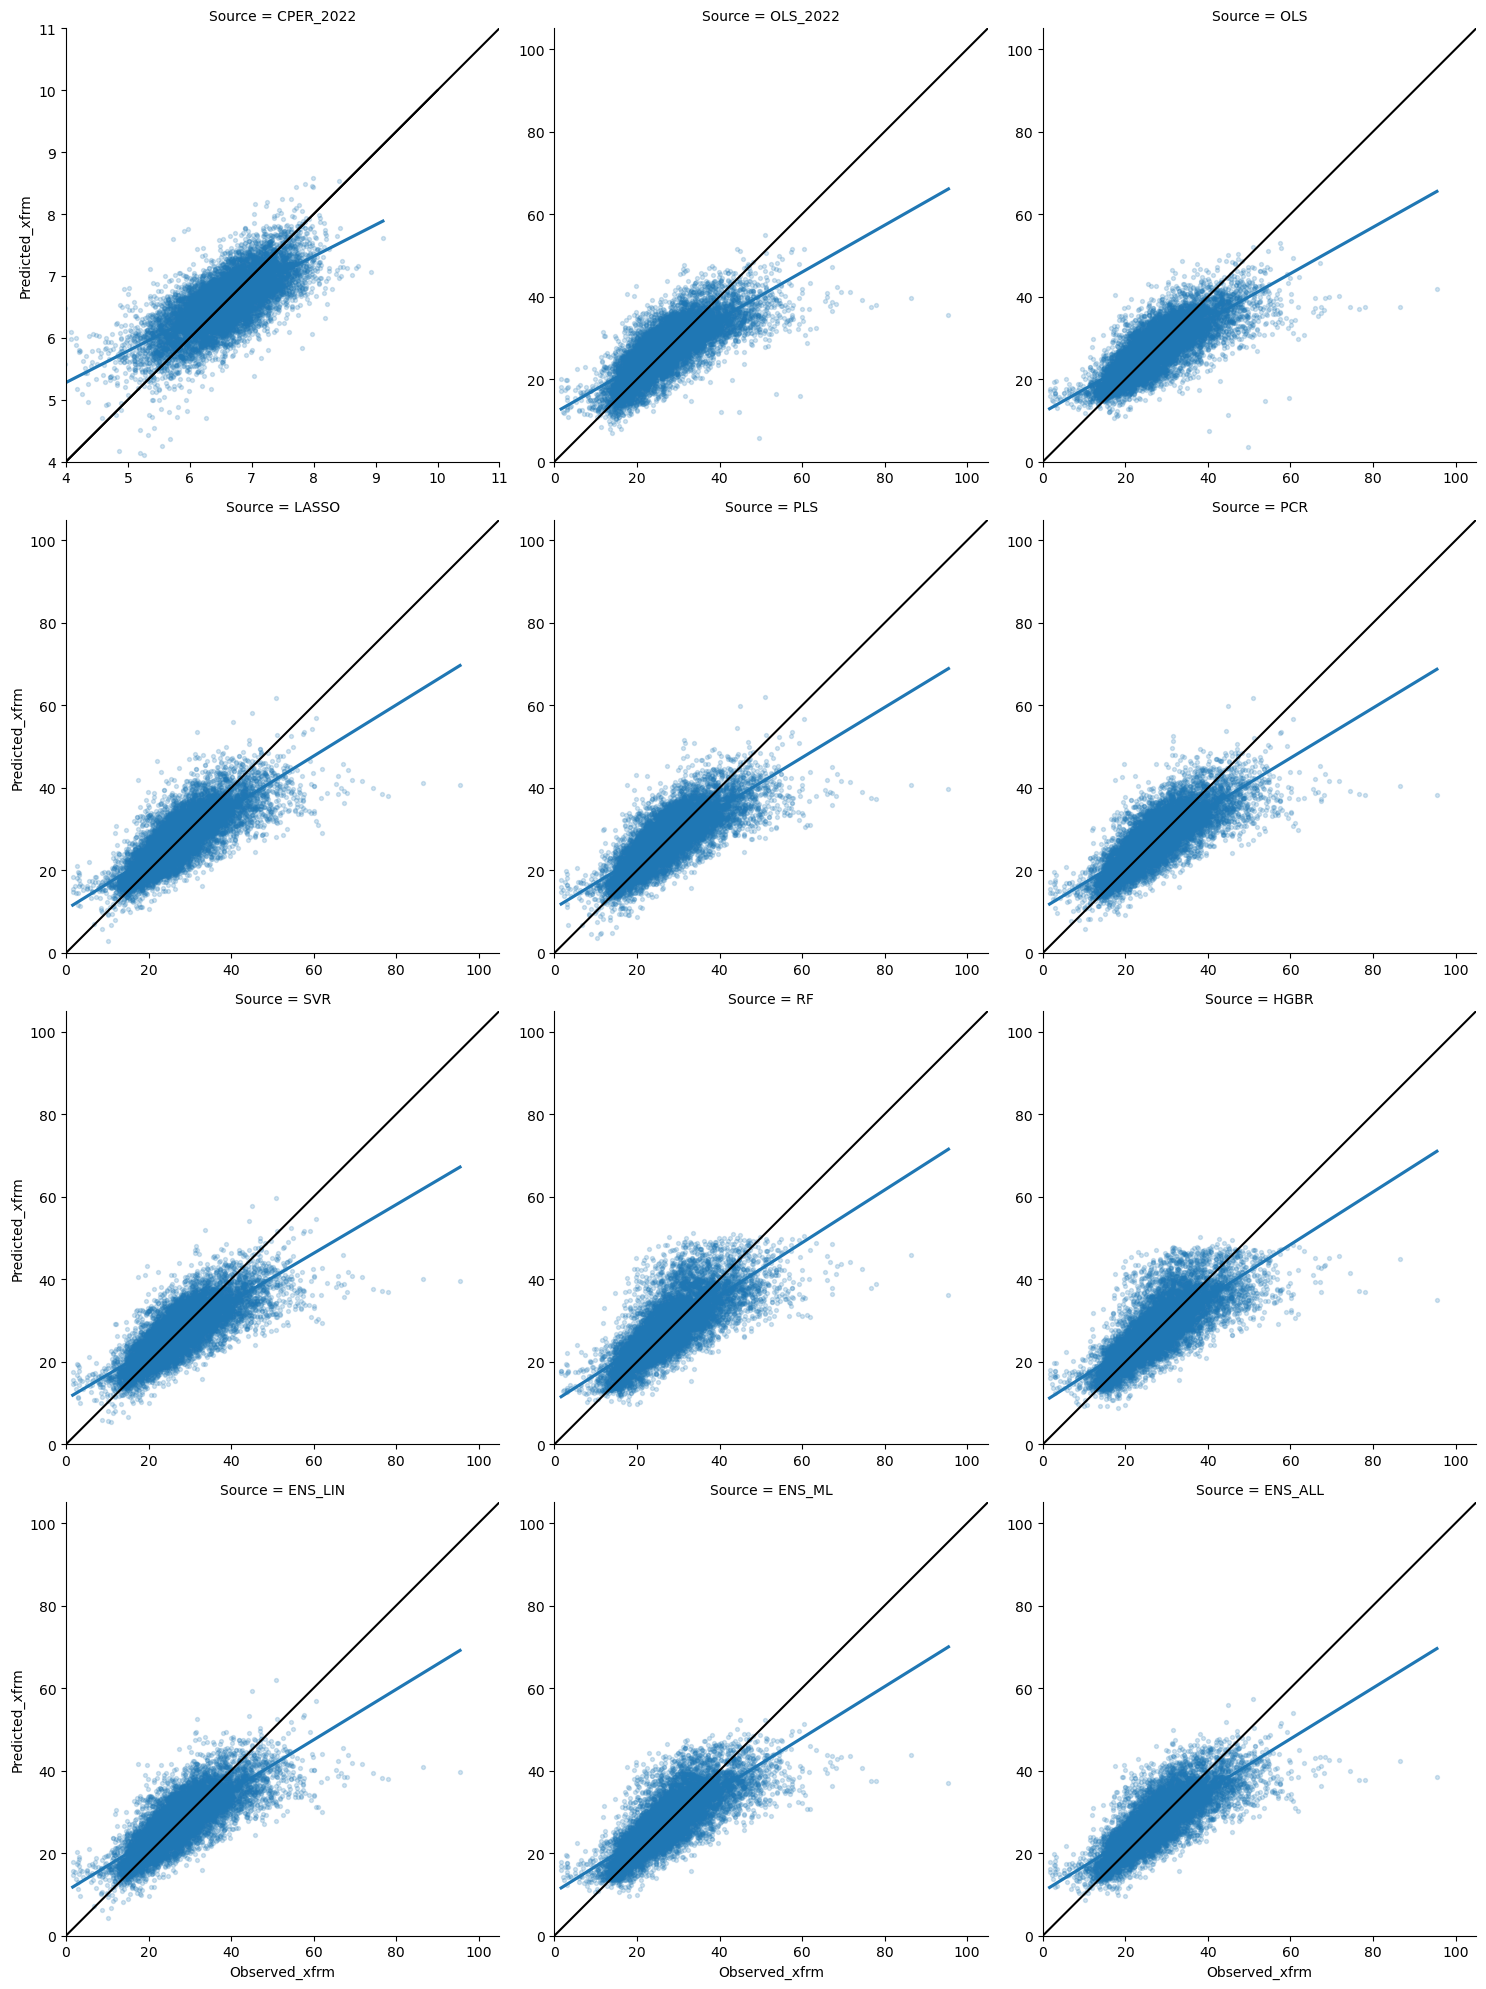

In [96]:
p_obs = sns.lmplot(df_bm_pred,
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3, ci=None,
                   facet_kws=dict(sharey=False, sharex=False,),
                    scatter_kws={'s': 8, 'alpha': 0.2, 'edgecolor': None})
for ax in p_obs.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.set_xlim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_obs.axes[0].set_ylim((4, 11))
p_obs.axes[0].set_xlim((4, 11))
p_obs.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')

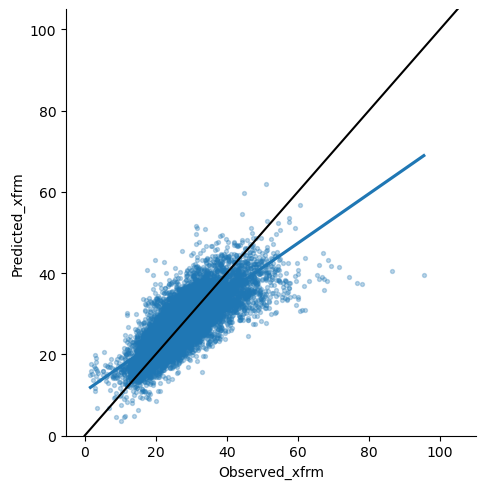

In [97]:
p_obs_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'],
               x='Observed_xfrm', y='Predicted_xfrm', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.3, 'edgecolor': None})
for ax in p_obs_best.axes.flatten():
        ax.set_ylim((0, max_lim_xfrm))
        ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

## Get aggregated predictions

### Transect

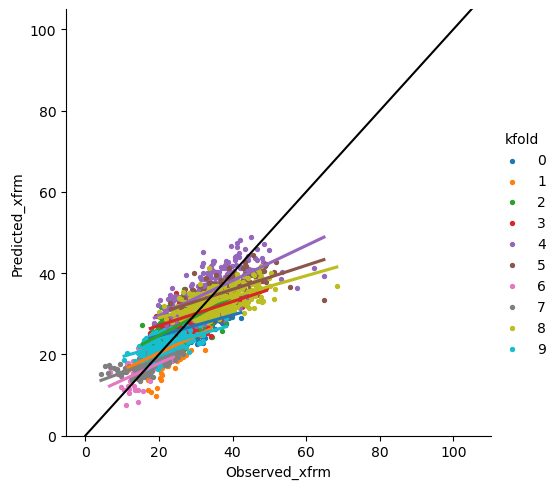

In [102]:
p_plot_best = sns.lmplot(df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby([logo_group, 'Plot', date_col], 
                                       observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', ci=None, hue=logo_group,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_plot_best.axes.flatten():
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')

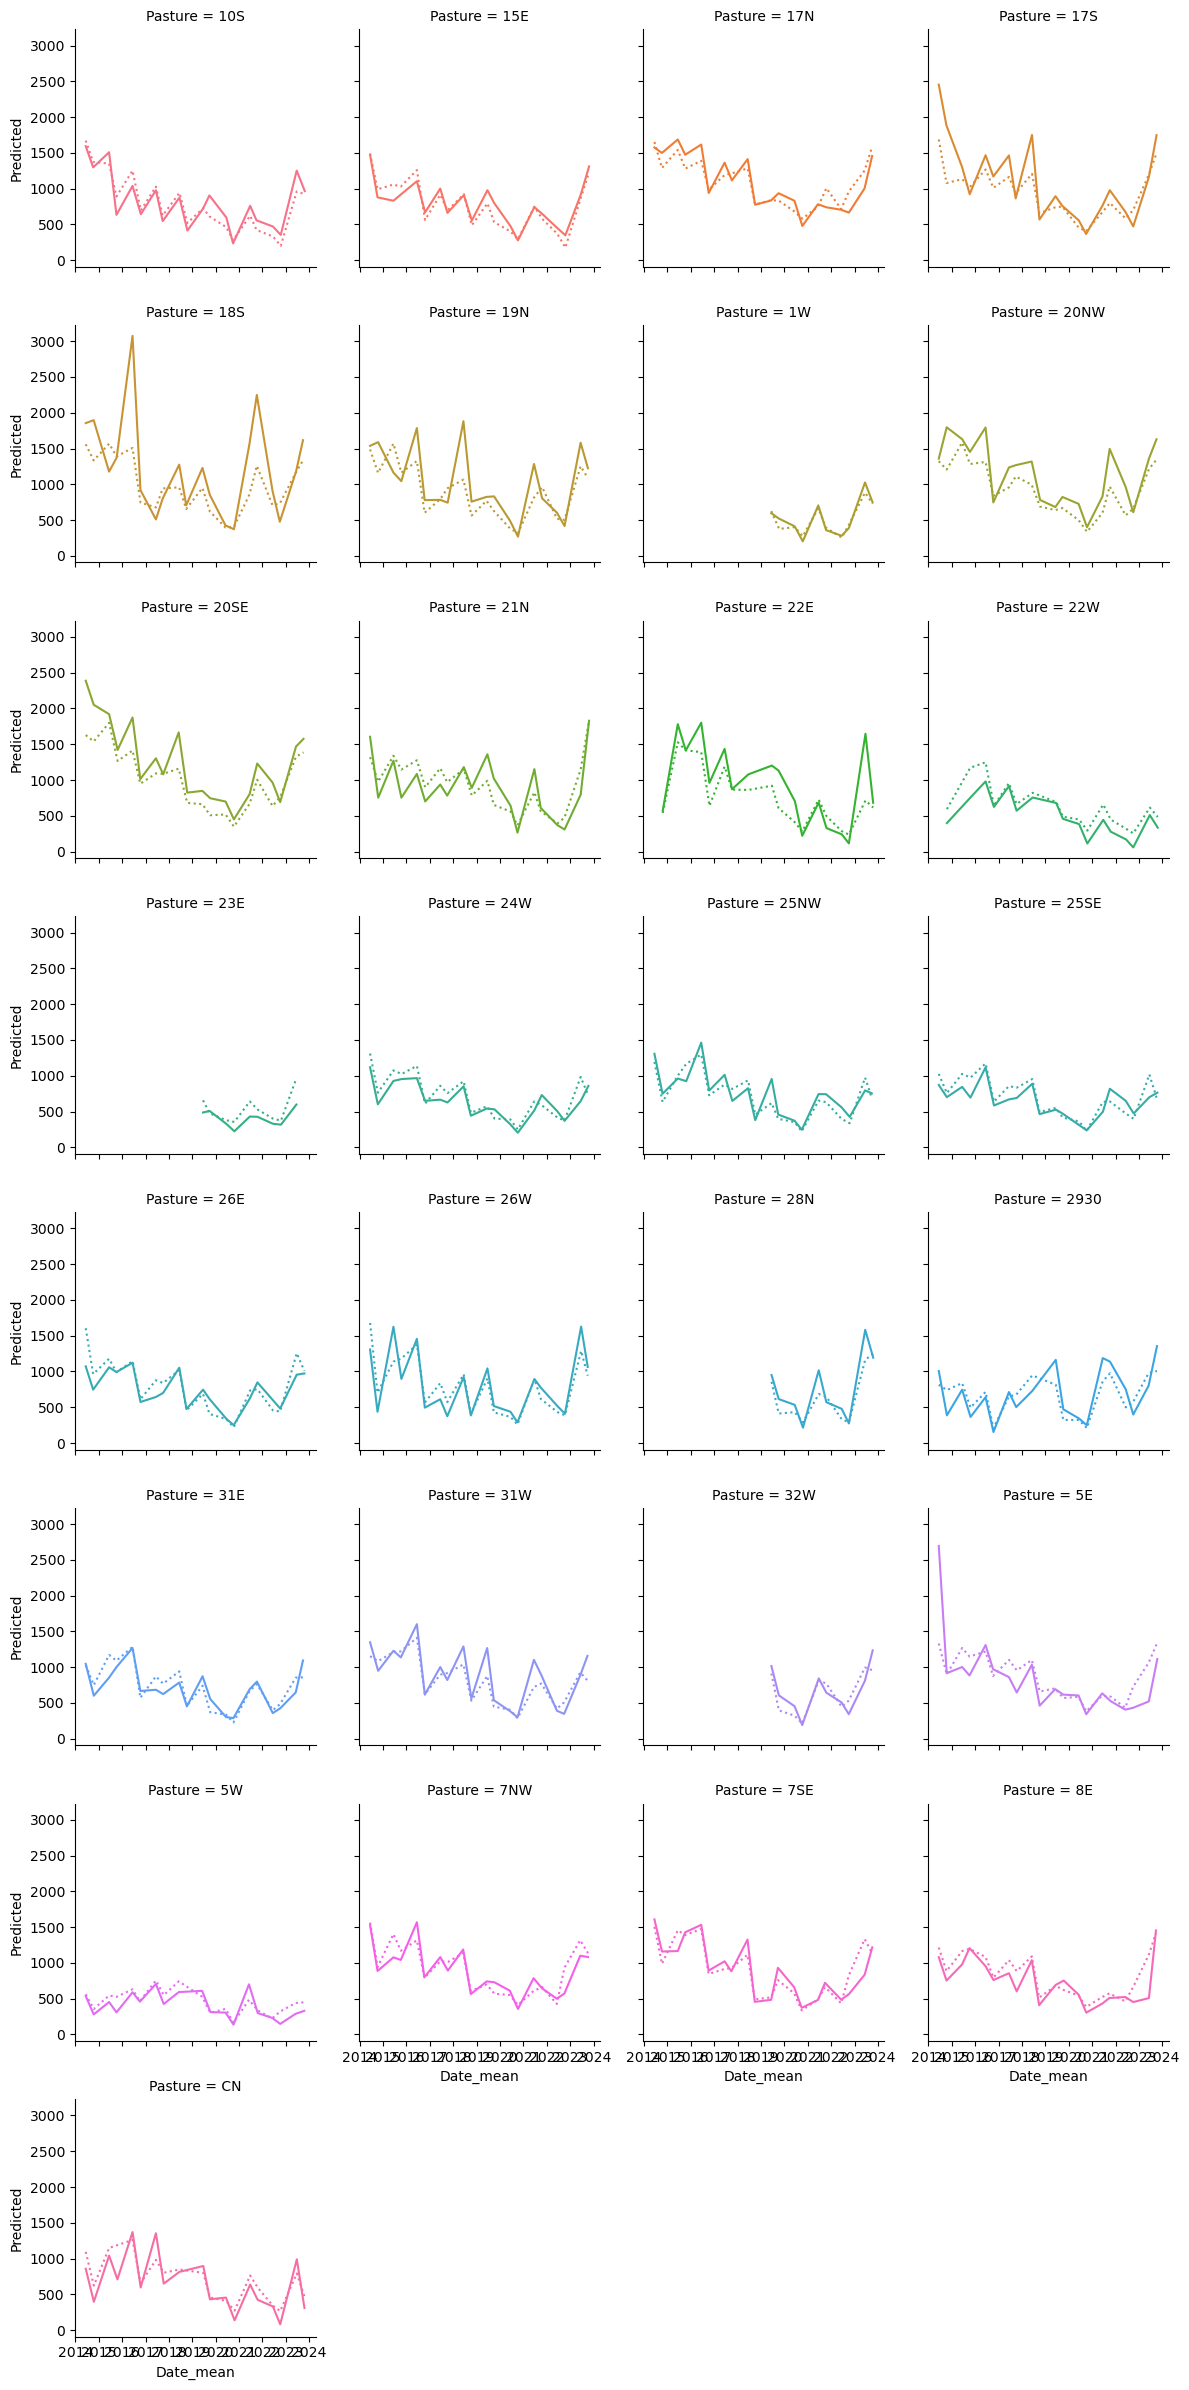

In [34]:
df_bm_pred[date_col] = pd.to_datetime(df_bm_pred[date_col])
df_bm_pred['DOY'] = df_bm_pred[date_col].dt.dayofyear
p_plot_ts_best = sns.FacetGrid(hue=past_col, 
                               data=df_bm_pred[df_bm_pred[mod_col] == 'PLS'].groupby(
                                   [past_col, 'DOY', date_col], 
                                   observed=True)[['Observed', 'Predicted']].mean().reset_index().sort_values([past_col, date_col]),
                               col=past_col, col_wrap=4, sharex=True)
p_plot_ts_best.map(plt.plot, date_col, 'Observed', linestyle='solid')
p_plot_ts_best.map(plt.plot, date_col, 'Predicted', linestyle='dotted')

### Pasture

In [35]:
mae_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(lambda x: abs(np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm'])),
                                                      include_groups=False).mean(), 
    include_groups=False).round(4)
bias_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted_xfrm']) - np.mean(x['Observed_xfrm']),
        include_groups=False).mean(), include_groups=False).round(4)
mae_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: abs(np.mean(x['Predicted']) - np.mean(x['Observed'])), 
        include_groups=False).mean(), include_groups=False).round(4)
bias_bt_pasture = df_bm_pred.groupby([mod_col, logo_group], observed=True).apply(
    lambda z: z.groupby([past_col] + group_cols).apply(
        lambda x: np.mean(x['Predicted']) - np.mean(x['Observed']), 
        include_groups=False).mean(), include_groups=False).round(4)
r2_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols, 
                                observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                                                observed=True).apply(
    lambda x: r2_score(x['Observed_xfrm'], x['Predicted_xfrm']), 
    include_groups=False).round(4)
r2_corr_pasture = df_bm_pred.groupby([mod_col, past_col, logo_group] + group_cols,
                                     observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index().dropna().groupby([mod_col, logo_group],
                                                                                          observed=True).apply(
    lambda x: r_corrcoef(x['Observed_xfrm'], x['Predicted_xfrm']),
    include_groups=False).round(4)

In [36]:
df_smry_pasture = pd.DataFrame({
    'MAE': mae_pasture.unstack(level=0).mean().round(4),
    'MAE_std': mae_pasture.unstack(level=0).std().round(4),
    'Bias': bias_pasture.unstack(level=0).mean().round(4),
    'Bias_std': bias_pasture.unstack(level=0).std().round(4),
    'R^2': r2_pasture.unstack(level=0).mean().round(4),
    'R^2_std': r2_pasture.unstack(level=0).std().round(4),
    'r': r2_corr_pasture.unstack(level=0).mean().round(4),
    'r_std': r2_corr_pasture.unstack(level=0).std().round(4),
    'MAE_bt': mae_bt_pasture.unstack(level=0).mean().round(4),
    'MAE_bt_std': mae_bt_pasture.unstack(level=0).std().round(4),
    'MAE_bt_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).mean().round(4),
    'MAE_bt_pct_std': (mae_bt_pasture / df_bm_pred.groupby([mod_col, past_col, logo_group], 
                                                    observed=True)['Observed'].mean()).unstack(level=0).std().round(4),
    'Bias_bt': bias_bt_pasture.unstack(level=0).mean().round(4),
    'Bias_bt_std': bias_bt_pasture.unstack(level=0).std().round(4),
})
display(df_smry_pasture)
if save_results:
    df_smry_pasture.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture.csv', os.path.basename(inPATH))))

df_smry_pasture_by_yr = pd.DataFrame({
    'MAE': mae_pasture.round(4),
    'Bias': bias_pasture.round(4),
    'MAE_bt': mae_bt_pasture.round(4),
    'MAE_pct': (mae_bt_pasture / df_bm_pred.groupby([mod_col, logo_group],
                                                    observed=True)['Observed'].mean()).round(4),
    'R^2': r2_pasture.round(4),
    'r': r2_corr_pasture.round(4)
})
#display(df_smry_pasture_by_yr.sort_values('r'))
if save_results:
    df_smry_pasture_by_yr.to_csv(os.path.join(outDIR,
                                     'tables/ml_models', 
                                     re.sub('tmp.csv', 'results_pasture_yrly.csv', os.path.basename(inPATH))))

,MAE,MAE_std,Bias,Bias_std,R^2,R^2_std,r,r_std,MAE_bt,MAE_bt_std,MAE_bt_pct,MAE_bt_pct_std,Bias_bt,Bias_bt_std
Source,,,,,,,,,,,,,,
CPER_2022,0.3281,0.0389,0.0287,0.1570,-0.1622,0.1999,0.2998,0.1086,270.6792,143.7621,0.3367,0.0839,-44.2351,126.4806
OLS_2022,3.7074,0.8268,0.1638,1.0436,0.1675,0.1303,0.4744,0.1183,221.5532,104.4276,0.2845,0.0781,-17.0850,56.4049
OLS,3.5096,0.8251,0.0890,0.5020,0.2093,0.1455,0.4732,0.1510,211.6363,100.3364,0.2685,0.0667,-25.7869,33.0727
LASSO,3.3108,0.8192,0.2440,0.4375,0.3125,0.1071,0.5727,0.0923,201.4756,101.5465,0.2533,0.0621,-11.7847,32.2465
PLS,3.4416,0.9482,0.2112,0.4706,0.2647,0.1487,0.5310,0.1348,209.7584,109.0210,0.2607,0.0651,-14.4532,31.4552
PCR,3.4348,0.9473,0.2556,0.4999,0.2692,0.1378,0.5281,0.1280,209.3042,108.4885,0.2602,0.0644,-11.0896,30.1831
SVR,3.4126,0.9094,-0.2900,0.3578,0.2658,0.1345,0.5268,0.1327,208.5831,106.7156,0.2603,0.0650,-45.6040,29.6701
RF,3.2686,0.9600,0.1947,0.9521,0.3328,0.1493,0.6006,0.1356,199.4591,108.4668,0.2476,0.0664,-25.0192,71.7033
HGBR,3.1778,0.8875,0.0799,0.2998,0.3583,0.1541,0.6018,0.1484,194.3297,101.5220,0.2425,0.0625,-24.8316,19.5071


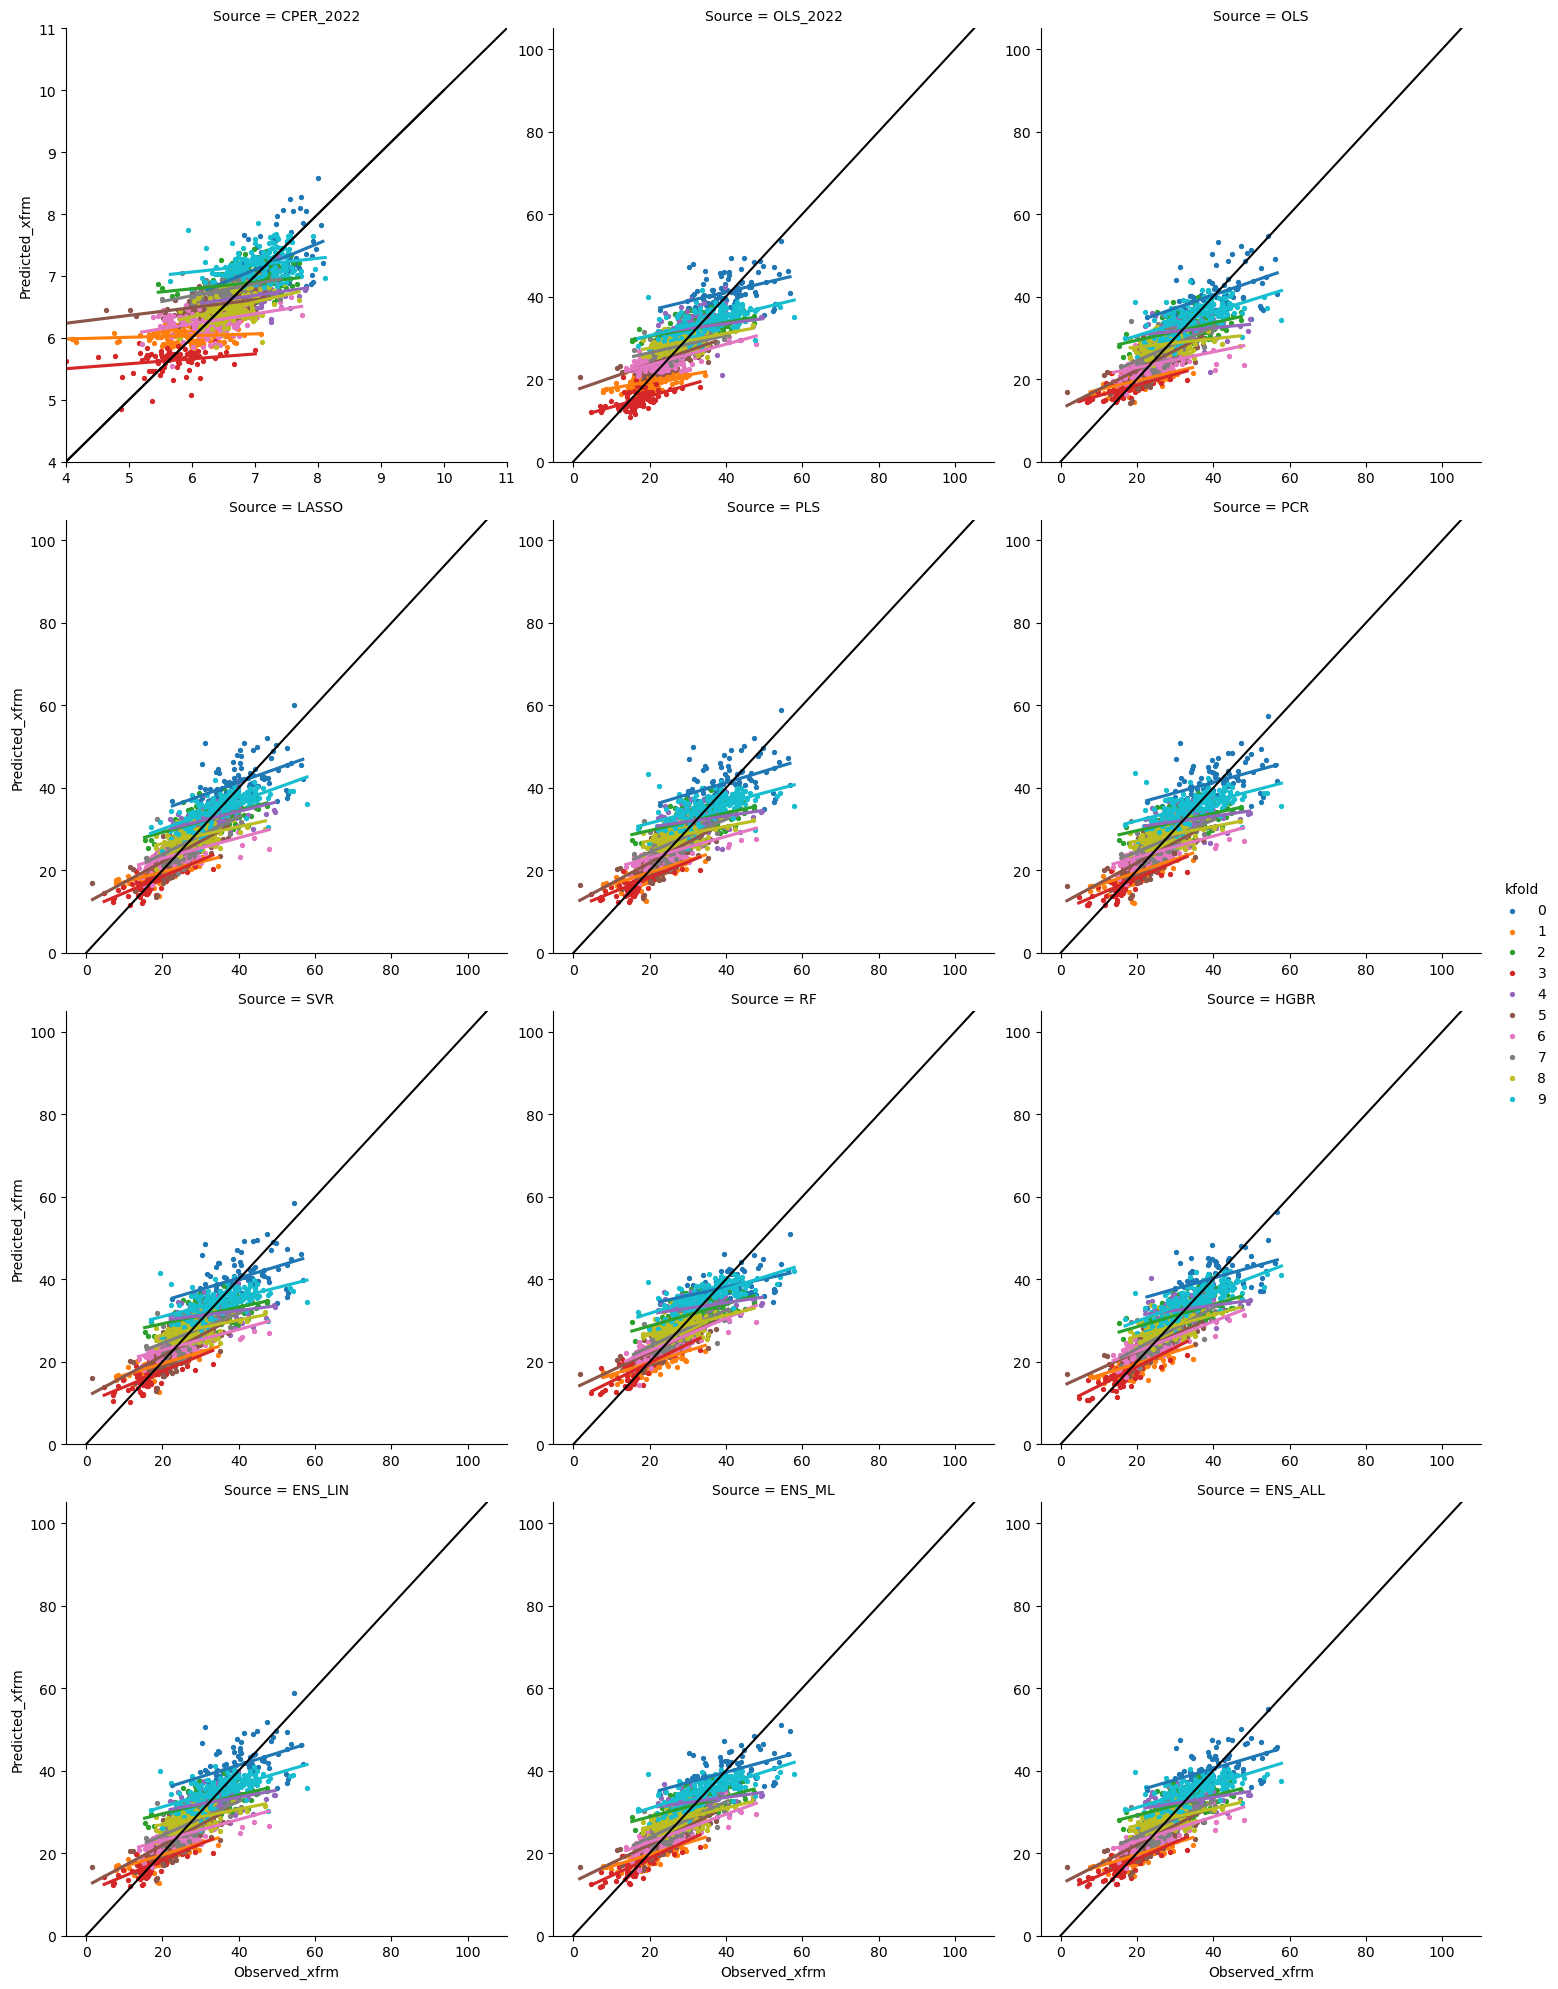

In [37]:
p_past = sns.lmplot(df_bm_pred.groupby(list(set([mod_col, logo_group, past_col] + group_cols)),
                                      observed=True)[['Observed_xfrm', 'Predicted_xfrm']].mean().reset_index(),
               x='Observed_xfrm', y='Predicted_xfrm', col=mod_col, col_wrap=3,
                    facet_kws=dict(sharey=False, sharex=False,),
                    hue=logo_group, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_past.axes:
    ax.set_ylim((0, max_lim_xfrm))
    ax.plot(np.arange(0, max_lim_xfrm), np.arange(0, max_lim_xfrm), c='black')
p_past.axes[0].set_ylim((4, 11))
p_past.axes[0].set_xlim((4, 11))
p_past.axes[0].plot(np.arange(4, 11), np.arange(4, 11), c='black')
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'results_pasture.png', os.path.basename(inPATH))), dpi=100)

## Extra plots (not currently used)

In [40]:
if 'Transect' in df_bm_pred.columns:
    p_trans = sns.lmplot(df_bm_pred, x='Observed', y='Predicted', col='Source', col_wrap=3, hue='Year', ci=None,
                         scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
    for ax in p_trans.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
    if save_results:
        plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_transect_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)
else:
    p_trans=None

In [41]:
p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Year', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

/local/scratch/sean.kearney/16107206/ipykernel_2918297/3509725408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  p_plot = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean']).mean().reset_index(),


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
p_pasture = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Year', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_plot_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Plot', 'Date_mean', 'Season']).mean().reset_index(),
               x='Observed', y='Predicted', col='Source', col_wrap=3,
               hue='Season', ci=None,
                    scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_plot_seas.axes:
        ax.set_ylim((0, 4000))
        ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_plot_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

In [ ]:
p_pasture_seas = sns.lmplot(df_bm_pred.groupby(['Year', 'Source', 'Pasture', 'Date_mean', 'Season']).mean().reset_index(), 
               x='Observed', y='Predicted', col='Source', col_wrap=3, 
               hue='Season', ci=None, 
                       scatter_kws={'s': 8, 'alpha': 0.25, 'edgecolor': None})
for ax in p_pasture_seas.axes:
    ax.set_ylim((0, 4000))
    ax.plot(np.arange(0, 4000), np.arange(0, 4000), c='black')
if save_results:
    plt.savefig(os.path.join('results/figures/ml_models', 'ml_yrly_pred_pasture_by_season_from_' + prefix + '_tuneby_' + tuneby_group + '.png'), dpi=100)

## Make variable importance dataframes

In [39]:
df_ols = mod_dict['OLS']['formula_df']

In [40]:
df_ols['features'] = df_ols['formula'].apply(lambda x: [f for f in x.split(' ~ ')[-1].split(' + ') if ':' not in f])

In [41]:
from tqdm import tqdm
"""
Calculated weighted relative variable importance for each variable across model types
"""
# set max vars based on where cross-validated metrics stop improving
max_vars = 3

var_names = list(set(df_ols['features'].sum()))

# Calculate decomposed R^2, relative variable importance (RVI) and AIC weights
df_ols_feats_ptn = pd.DataFrame(columns=['kfold', 'features', 'formula', 'RVI', 'weight'])
for k in df_ols['kfold'].unique():
    print(k)
    df_ols_sub_tmp = df_ols[(df_ols['kfold'] == k) &
    (df_ols['numb_vars'] <= max_vars)].copy()
    min_aic = (df_ols_sub_tmp['AIC']*0.001).min()
    df_ols_sub_tmp['AICw'] = [np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)] / \
    np.sum([np.exp(-0.5 * x) for x in (df_ols_sub_tmp['AIC']*0.001 - min_aic)])
    for f in tqdm(var_names):
        df_ols_sub_f = df_ols_sub_tmp[[f in n for n in df_ols_sub_tmp['formula']]]
        if len(df_ols_sub_f) == 0:
            continue
        else:
            for f_form in df_ols_sub_f['formula']:
                f_form_omitted = re.sub(f + ":[^\+]* \+ ", "",
                                        re.sub(" \+ " + f + ":[^\+]*", "",
                                               re.sub(" \+ " + f + ":.+?(?= |$)", "",
                                                      re.sub(" \+(?<=\+)[^\+]*:" + f, "",
                                                             re.sub("\+ " + f + " (?=\+)", "",
                                                                    re.sub("(?<=~ )" + f + " \+ ", "",
                                                                           f_form))))))

                # print(f_form)
                # print(f_form_omitted)
                RVI_tmp = df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['R2_adj'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                OVI_tmp = df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form)].values - \
                          df_ols_sub_tmp['mae_orig_mean'][(df_ols_sub_tmp['formula'] == f_form_omitted)].values
                weight_tmp = df_ols_sub_tmp['AICw'][(df_ols_sub_tmp['formula'] == f_form)].values

                df_ols_feats_tmp = pd.DataFrame(dict(kfold=k,
                                                     features=f,
                                                     formula=f_form,
                                                     RVI=np.mean(RVI_tmp),
                                                     weight=weight_tmp),
                                                index=[0])
                df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])

2014


  0%|          | 0/28 [00:00<?, ?it/s]/local/scratch/sean.kearney/16301936/ipykernel_438907/2421960830.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_ols_feats_ptn = pd.concat([df_ols_feats_ptn,df_ols_feats_tmp])
100%|██████████| 28/28 [00:07<00:00,  3.96it/s]


2015


100%|██████████| 28/28 [00:07<00:00,  3.81it/s]


2016


100%|██████████| 28/28 [00:07<00:00,  3.65it/s]


2017


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


2018


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


2019


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


2020


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


2021


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


2022


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


2023


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


In [42]:
def feature_type(f):
    if f in ['RED', 'GREEN', 'BLUE', 'NIR', 'SWIR1', 'SWIR2']:
        return 'Band'
    elif 'BAI' in f:
        return 'BAI'
    else:
        return 'Veg. Index'

# calculate weighted relative variable importance (RVIw)
df_ols_feats_ptn['RVIw'] = df_ols_feats_ptn['RVI'] * df_ols_feats_ptn['weight']

# add input variable group field
df_ols_feats_ptn['group'] = df_ols_feats_ptn['features'].apply(feature_type)

# calculate sorted mean RVIw for each feature after summing across each kfold
df_ols_feats_grp = df_ols_feats_ptn.groupby(['kfold',
                                             'features',
                                             'group'])['RVIw'].sum().reset_index()
df_ols_feats_grp['RVIw_norm'] = df_ols_feats_grp.groupby('kfold')['RVIw'].transform(lambda x: x / x.mean())
df_ols_feats_grp['RVIw_mean'] = df_ols_feats_grp.groupby(['features'])['RVIw'].transform('mean')
df_ols_feats_grp = df_ols_feats_grp.sort_values(['RVIw_mean'], ascending=False).reset_index(drop=True)

In [43]:
df_ols_feats_grp['kfold'] = df_ols_feats_grp['kfold'].astype('str')
if kfold_group == 'Year':
    df_ols_feats_grp['kfold'] = pd.Categorical(df_ols_feats_grp['kfold'], 
                                               [str(x) for x in range(min(df_ols_feats_grp['kfold'].astype(int)),
                                                                      max(df_ols_feats_grp['kfold'].astype(int))+1)])

In [44]:
df_lasso_coefs = mod_dict['LASSO']['variable_df']
df_lasso_coefs['kfold'] = pd.Categorical(df_lasso_coefs['kfold'], categories=df_lasso_coefs['kfold'].sort_values().unique())
df_lasso_coefs['Coef_abs'] = abs(df_lasso_coefs['Coef'])
df_lasso_coefs_ranked = df_lasso_coefs.groupby('Variable', observed=True)['Coef_abs'].mean().sort_values(ascending=False)
df_lasso_coefs['Variable'] = pd.Categorical(df_lasso_coefs['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs['Coef_norm'] = df_lasso_coefs.groupby('kfold', observed=True)['Coef_abs'].transform(lambda x: x / x.mean())

dfs_lasso = []
for k in df_lasso_coefs['kfold'].unique():
    dfs_lasso_tmp = pd.DataFrame(data={'Variable': df_ols_feats_grp['features'].unique()})
    dfs_lasso_tmp['kfold'] = k
    dfs_lasso.append(dfs_lasso_tmp)
df_lasso_coefs_all = pd.concat(dfs_lasso)
df_lasso_coefs_all['Coef_abs_sum'] = 0.0
for k in df_lasso_coefs_all['kfold'].unique(): 
    for i in df_lasso_coefs_all['Variable']:
        df_lasso_coefs_all.loc[(df_lasso_coefs_all['Variable'] == i) & 
        (df_lasso_coefs_all['kfold'] == k),
        'Coef_abs_sum'] = df_lasso_coefs[df_lasso_coefs['kfold'] == k][[i in x for x in df_lasso_coefs[df_lasso_coefs['kfold'] == k]['Variable']]]['Coef_abs'].sum()
df_lasso_coefs_all['kfold'] = pd.Categorical(df_lasso_coefs_all['kfold'], categories=df_lasso_coefs_all['kfold'].sort_values().unique())
df_lasso_coefs_ranked = df_lasso_coefs_all.groupby('Variable', observed=True)['Coef_abs_sum'].mean().sort_values(ascending=False)
df_lasso_coefs_all['Variable'] = pd.Categorical(df_lasso_coefs_all['Variable'], categories=df_lasso_coefs_ranked.index.values)
df_lasso_coefs_all['Coef_norm'] = df_lasso_coefs_all.groupby('kfold', observed=True)['Coef_abs_sum'].transform(lambda x: x / x.mean()) 

In [45]:
df_pls_coefs = mod_dict['PLS']['variable_df']
df_pls_coefs['kfold'] = pd.Categorical(df_pls_coefs['kfold'], categories=df_pls_coefs['kfold'].sort_values().unique())
df_pls_coefs_ranked = df_pls_coefs.groupby('Variable', observed=True)['VIP'].mean().sort_values(ascending=False)
df_pls_coefs['Variable'] = pd.Categorical(df_pls_coefs['Variable'], categories=df_pls_coefs_ranked.index.values)
df_pls_coefs_top = df_pls_coefs[df_pls_coefs['VIP'] > 1.0].copy()
df_pls_coefs_top['Variable'] = df_pls_coefs_top['Variable'].cat.remove_unused_categories()

In [46]:
df_pcr_coefs = mod_dict['PCR']['variable_df']
df_pcr_coefs['kfold'] = pd.Categorical(df_pcr_coefs['kfold'], categories=df_pcr_coefs['kfold'].sort_values().unique())
pcr_coefs_abs_mean = df_pcr_coefs.groupby(['kfold', 'Variable'], observed=True).apply(lambda x: np.mean(np.abs(x), axis=1),
                                                                                     include_groups=False)
pcr_coefs_abs_mean.name = 'Coef_mean_abs'
df_pcr_coefs_mean = pcr_coefs_abs_mean.reset_index()

df_pcr_coefs_mean['Coef_mean_norm'] = df_pcr_coefs_mean.groupby('kfold', observed=True)['Coef_mean_abs'].transform(lambda x: x / x.mean())
pcr_vars_mean_ranked = df_pcr_coefs_mean.groupby('Variable', observed=True)['Coef_mean_abs'].mean().sort_values(ascending=False)
df_pcr_coefs_mean['Variable'] = pd.Categorical(df_pcr_coefs_mean['Variable'], categories=pcr_vars_mean_ranked.index.values)

df_pcr_coefs_mean_top20 = df_pcr_coefs_mean[df_pcr_coefs_mean['Variable'].isin(pcr_vars_mean_ranked.head(20).index.values)].copy()
df_pcr_coefs_mean_top20['Variable'] = df_pcr_coefs_mean_top20['Variable'].cat.remove_unused_categories()

In [47]:
df_svr_wts = mod_dict['SVR']['variable_df'].copy()
df_svr_wts['kfold'] = pd.Categorical(df_svr_wts['kfold'], categories=df_svr_wts['kfold'].sort_values().unique())
df_svr_wts['SVR_weights_abs'] = df_svr_wts['SVR_weights'].transform(lambda x: abs(x))
df_svr_wts['SVR_weights_norm'] = df_svr_wts.groupby('kfold', observed=True)['SVR_weights_abs'].transform(lambda x: x / x.mean())
df_svr_wts_ranked = df_svr_wts.groupby('Variable', observed=True)['SVR_weights_abs'].mean().sort_values(ascending=False)
df_svr_wts['Variable'] = pd.Categorical(df_svr_wts['Variable'], categories=df_svr_wts_ranked.index.values)

In [48]:
df_rf_mdi = mod_dict['RF']['variable_df'].copy()
df_rf_mdi['kfold'] = pd.Categorical(df_rf_mdi['kfold'], categories=df_rf_mdi['kfold'].sort_values().unique())
df_rf_mdi['MDI_norm'] = df_rf_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
df_rf_mdi_ranked = df_rf_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
df_rf_mdi['Variable'] = pd.Categorical(df_rf_mdi['Variable'], categories=df_rf_mdi_ranked.index.values)

In [49]:
#df_gbr_mdi = mod_dict['GBR']['variable_df'].copy()
#df_gbr_mdi['kfold'] = pd.Categorical(df_gbr_mdi['kfold'], categories=df_gbr_mdi['kfold'].sort_values().unique())
#df_gbr_mdi['MDI_norm'] = df_gbr_mdi.groupby('kfold', observed=True)['MDI'].transform(lambda x: x / x.mean())
#df_gbr_mdi_ranked = df_gbr_mdi.groupby('Variable', observed=True)['MDI_norm'].mean().sort_values(ascending=False)
#df_gbr_mdi['Variable'] = pd.Categorical(df_gbr_mdi['Variable'], categories=df_gbr_mdi_ranked.index.values)

In [50]:
df_hgbr_pi = mod_dict['HGBR']['variable_df'].copy()
df_hgbr_pi['kfold'] = pd.Categorical(df_hgbr_pi['kfold'], categories=df_hgbr_pi['kfold'].sort_values().unique())
df_hgbr_pi['PI_norm'] = df_hgbr_pi.groupby('kfold', observed=True)['PI'].transform(lambda x: x / x.mean())
df_hgbr_pi_ranked = df_hgbr_pi.groupby('Variable', observed=True)['PI_norm'].mean().sort_values(ascending=False)
df_hgbr_pi['Variable'] = pd.Categorical(df_hgbr_pi['Variable'], categories=df_hgbr_pi_ranked.index.values)

In [51]:
df_ols_feats_grp['Model'] = 'OLS'
df_ols_feats_grp['VI'] = df_ols_feats_grp['RVIw_norm']
df_ols_feats_grp['Variable'] = df_ols_feats_grp['features']

df_lasso_coefs_all['Model'] = 'LASSO'
df_lasso_coefs_all['VI'] = df_lasso_coefs_all['Coef_norm']

df_pls_coefs['Model'] = 'PLS'
df_pls_coefs['VI'] = df_pls_coefs['VIP']

df_pcr_coefs_mean['Model'] = 'PCR'
df_pcr_coefs_mean['VI'] = df_pcr_coefs_mean['Coef_mean_norm']

df_svr_wts['Model'] = 'SVR'
df_svr_wts['VI'] = df_svr_wts['SVR_weights_norm']

df_rf_mdi['Model'] = 'RF'
df_rf_mdi['VI'] = df_rf_mdi['MDI_norm']

#df_gbr_mdi['Model'] = 'GBR'
#df_gbr_mdi['VI'] = df_gbr_mdi['MDI_norm']

df_hgbr_pi['Model'] = 'HGBR'
df_hgbr_pi['VI'] = df_hgbr_pi['PI_norm']

vi_cols_list = ['Model','kfold', 'Variable', 'VI']

df_vi_all = pd.concat([df_lasso_coefs_all[vi_cols_list],
                       df_pls_coefs[vi_cols_list],
                       df_pcr_coefs_mean[vi_cols_list],
                       df_svr_wts[vi_cols_list],
                       df_rf_mdi[vi_cols_list],
                       #df_gbr_mdi[vi_cols_list],
                       df_hgbr_pi[vi_cols_list]])
df_vi_all = df_vi_all.reset_index(drop=True)

### Variable importance plots

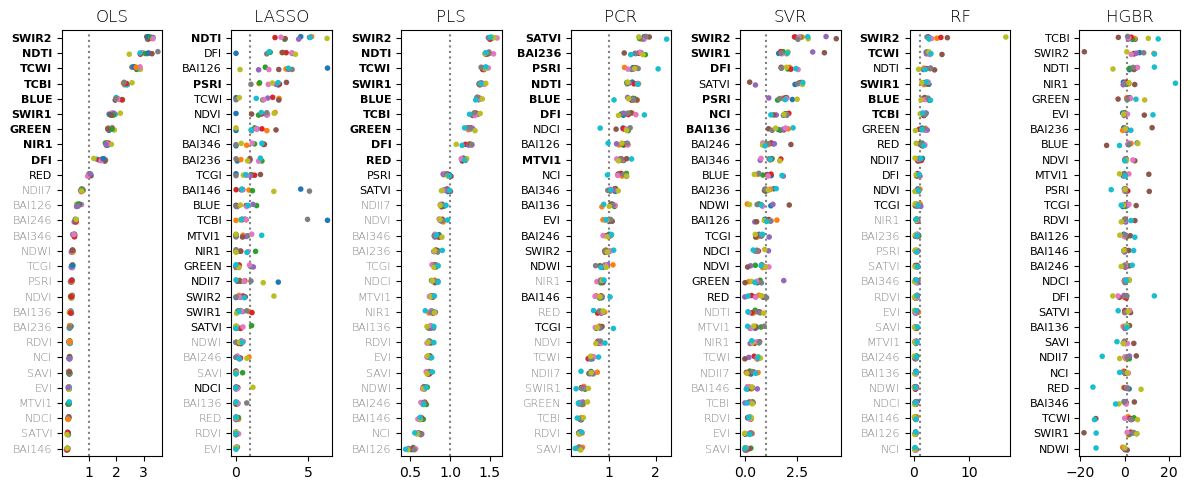

In [54]:
fig, axs = plt.subplots(ncols=7, nrows=1, figsize=(12, 5), 
                        sharex=False, sharey=False)
for idx, df_tmp in enumerate([df_ols_feats_grp,
                              df_lasso_coefs_all,
                              df_pls_coefs,
                              df_pcr_coefs_mean,
                              df_svr_wts,
                              df_rf_mdi,
                              df_hgbr_pi]):
    df_tmp['Variable'] = df_tmp['Variable'].apply(lambda x: re.sub('_', '', x))
    #top_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() >= 1.0]
    top_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] >= 1.0)]
    #bottom_vars = [x for x in df_tmp['Variable'].unique() if df_tmp[df_tmp['Variable'] == x]['VI'].mean() < 1.0]
    bottom_vars = [x for x in df_tmp['Variable'].unique() if np.all(df_tmp[df_tmp['Variable'] == x]['VI'] < 1.0)]
    sns.stripplot(y='Variable', x='VI', data=df_tmp, size=4,
                  hue='kfold', orient='h',
                  ax=axs.flatten()[idx], legend=False)
    for ytick in axs.flatten()[idx].get_yticklabels():
        if ytick.get_text() in top_vars:
            ytick.set_fontweight(800)
        elif ytick.get_text() in bottom_vars:
            ytick.set_fontweight(100)
            ytick.set_color('grey')
    axs.flatten()[idx].yaxis.set_tick_params(labelsize=8)
    axs.flatten()[idx].axvline(x=1.0, linestyle='dotted', color='grey')
    axs.flatten()[idx].set_title(df_tmp['Model'].unique()[0], fontweight=10)
    #if idx > 3:
    #    axs.flatten()[idx].set_xlabel('Variable importance')
    #else:
    axs.flatten()[idx].set_xlabel(None)
    axs.flatten()[idx].set_ylabel(None)
plt.tight_layout()
if save_results:
    plt.savefig(os.path.join(outDIR, 
                             'figures/ml_models', 
                             re.sub('tmp.csv', 'vi_all.png', os.path.basename(inPATH))), dpi=100)

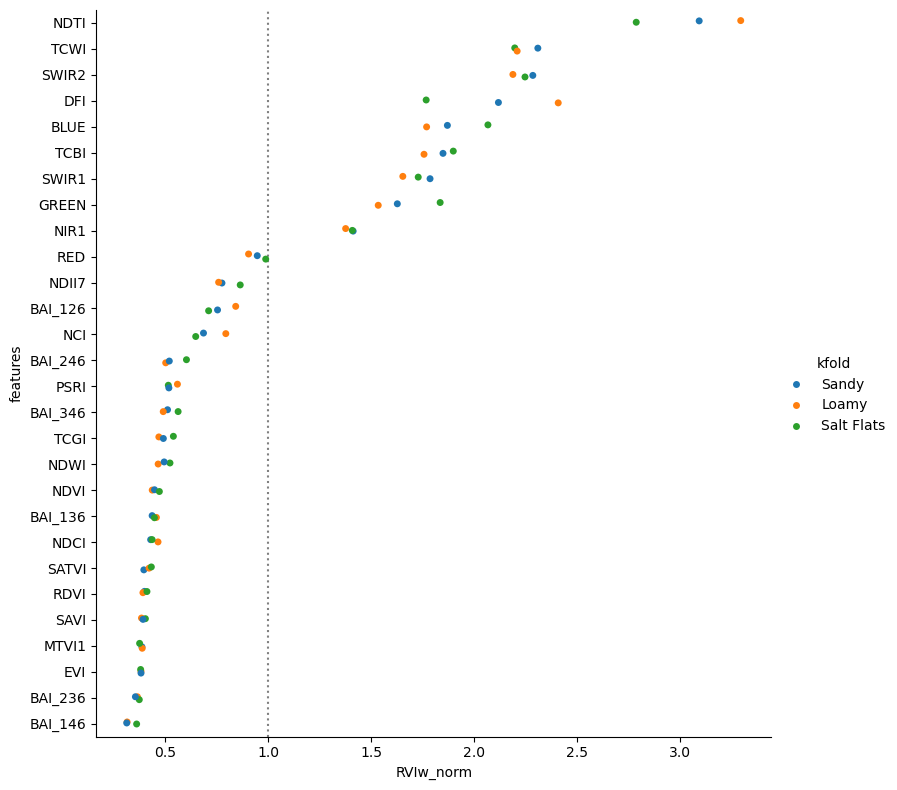

In [86]:
p = sns.catplot(y='features', x='RVIw_norm', hue='kfold',# hue_order=['Band', 'Veg. Index', 'BAI'],
                orient='h',# palette=sns.color_palette()[6:-1],
                data=df_ols_feats_grp,
                height=8, aspect=1.0)
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#if save_results:
#    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_ols.png', os.path.basename(inPATH))), dpi=100)

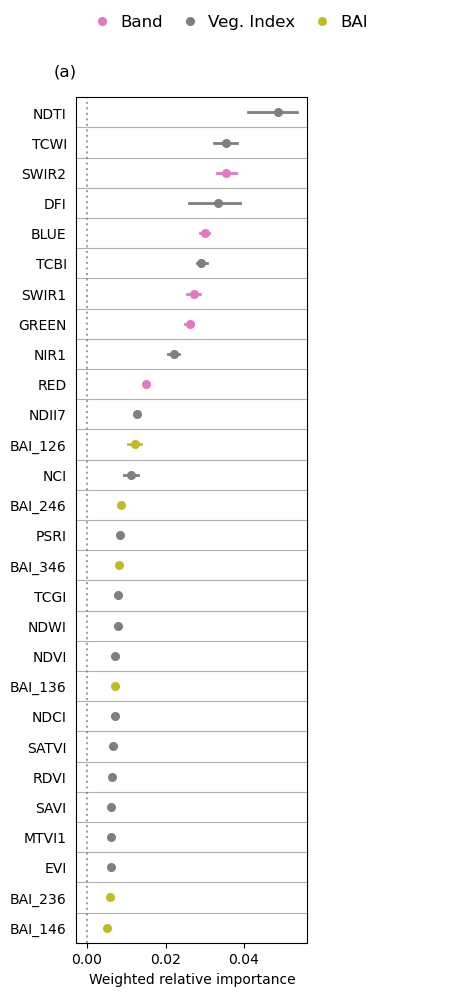

In [87]:
"""
Figure 2: Plot variable importance calculated from all model subsets
"""
font_sml = 10
font_med=12
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1, 2, 1)
pplot1 = sns.pointplot(y='features', x='RVIw', hue='group', hue_order=['Band', 'Veg. Index', 'BAI'],
                       orient='h', dodge=False, ax=ax1, linestyles='None', linewidth=2.0,
                       palette=sns.color_palette()[6:-1],
                       err_kws=dict(linewidth=2.0),
                       data=df_ols_feats_grp)
ax1.set_ylabel('')
ax1.set_xlabel('Weighted relative importance', fontsize=font_sml)
ax1.get_legend().remove()
#ax1.set_xlim((-0.10, 0.50))
ax1.set_yticks(np.arange(0.5, len(df_ols_feats_grp['features'].unique()) - 1, 1), minor=True)
ax1.grid(which='minor', axis='y')
for tic in ax1.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
for tic in ax1.yaxis.get_minor_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)
ax1.axvline(x=0, color='grey', alpha=0.75, linestyle='dotted')
ax1.tick_params(axis='x', which='major', labelsize=font_sml)
ax1.tick_params(axis='y', which='major', labelsize=font_sml)
ax1.text(x=-0.1, y=1.025, s='(a)', transform=ax1.transAxes, size=font_med)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(labels), fontsize=font_med,
           columnspacing=0.6, handletextpad=0.1, frameon=False)
plt.tight_layout(w_pad=3.0, rect=(0, 0, 1, 0.95))
if save_results:
    plt.savefig(outDIR_figs + mod_dir_dict[mod_type] + mod_type + '_variable_importance.png', dpi=600,
                bbox_inches='tight', pad_inches=0.2)
    plt.close()

In [ ]:
p = sns.catplot(df_lasso_coefs_all, x='Coef_norm', y='Variable', hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
#for ax in p.axes.flatten():
#    ax.tick_params(axis='x', rotation=90)

In [ ]:
p = sns.catplot(df_pls_coefs, x='VIP', y='Variable',  hue='kfold', height=8, aspect=1.0, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_pcr_coefs_mean,
                x='Coef_mean_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')

In [ ]:
p = sns.catplot(df_svr_wts,
                x='SVR_weights_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_svr.png', os.path.basename(inPATH))), dpi=100)

In [94]:
df_svr_wts.groupby('Variable', observed=True)['SVR_weights_norm'].mean()

Variable
SWIR2      3.248787
SWIR1      2.497594
BAI_136    1.827635
NCI        1.629908
NDVI       1.508274
DFI        1.335951
NDWI       1.319505
BAI_346    1.346744
GREEN      1.211063
BLUE       1.172355
PSRI       1.150184
NDCI       1.038067
BAI_126    1.055384
SATVI      0.929783
BAI_236    0.834357
NDTI       0.819090
TCGI       0.726233
BAI_246    0.652782
BAI_146    0.590613
EVI        0.525799
NDII7      0.511270
TCWI       0.523419
RED        0.451092
RDVI       0.442271
SAVI       0.302825
MTVI1      0.130662
NIR1       0.113749
TCBI       0.104606
Name: SVR_weights_norm, dtype: float64

In [ ]:
p = sns.catplot(df_rf_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_rf.png', os.path.basename(inPATH))), dpi=100)

In [ ]:
p = sns.catplot(df_gbr_mdi,
                x='MDI_norm', y='Variable',  hue='kfold', height=6, aspect=1, orient='h')
for ax in p.axes.flatten():
    ax.axvline(x=1.0, linestyle='dotted', color='grey')
if save_results:
    plt.savefig(os.path.join(outDIR, 'figs/varimp/', re.sub('tmp.csv', 'varimp_gbr.png', os.path.basename(inPATH))), dpi=100)

## Make parameter tuning dataframes

In [55]:
param_dfs = {}
for k in mod_dict:
    if 'tune_results' in mod_dict[k].keys():
        for idx, kfold in enumerate(mod_dict[k]['tune_results']):
            if idx == 0:
                param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results'][kfold]['params']]))
                #param_dfs[k] = pd.DataFrame(columns=['Model', 'kfold', 'Best', 'MAE'] + param_names)
            df_tmp = pd.DataFrame({'Model': k,
                                   'kfold': str(kfold),
                                   'Best': 0,
                                   'MAE': mod_dict[k]['tune_results'][kfold]['mean_test_MAE'],
                                   #'R2': mod_dict[k]['tune_results'][kfold]['mean_test_R2'],
                                   #'R2_train': mod_dict[k]['tune_results'][kfold]['mean_train_R2']
                                  })
            for p in param_names:
                df_tmp[p] = mod_dict[k]['tune_results'][kfold]['param_' + p].data
            idx_best = mod_dict[k]['tune_results'][kfold]['rank_test_MAE'].argmin()
            df_tmp.loc[idx_best, 'Best'] = 1
            if idx == 0:
                param_dfs[k] = df_tmp
            else:
                param_dfs[k] = pd.concat([param_dfs[k], df_tmp.dropna(how='all', axis=0)])
        if k in param_dfs.keys():
            param_dfs[k] = param_dfs[k].reset_index(drop=True)

In [113]:
param_dfs['PCR']

,Model,kfold,Best,MAE,pca__n_components
0,PCR,2014,0,-5.987544,1
1,PCR,2014,0,-5.208924,2
2,PCR,2014,0,-4.376159,3
3,PCR,2014,0,-4.349545,4
4,PCR,2014,0,-4.304866,5
...,...,...,...,...,...
125,PCR,2023,0,-4.247566,9
126,PCR,2023,0,-4.168809,10
127,PCR,2023,1,-4.105374,11
128,PCR,2023,0,-4.107210,12


In [134]:
param_dict = {
    'LASSO_1': 'LASSO__alpha',
    'PLS_1': 'PLS__n_components',
    'PCR_1': 'pca__n_components',
    'SVR_1': 'SVR__C',
    'SVR_2': 'SVR__epsilon',
    'RF_1': 'RF__max_features',
    'RF_2': 'RF__max_samples',
    'RF_3': 'RF__min_samples_split',
    'RF_4': 'RF__n_estimators',
    'HGBR_5': 'GBR__learning_rate',
    'HGBR_6': 'GBR__max_features',
    'HGBR_7': 'GBR__min_samples_leaf'   
}

log_list = ['LASSO__alpha', 'SVR__C', 'SVR__epsilon', 'GRB__learning_rate']
drop_cols = ['Model', 'kfold', 'Best', 'MAE']

In [148]:
df_combos = pd.DataFrame(columns=['Model', 'unique_combos', 'max_combos', 'possible_combos'])
for idx, ks in enumerate(['LASSO', 'PCR', 'PLS', 'SVR', 'RF', 'HGBR']):
    combos_all_tmp = param_dfs[ks][[c for c in param_dfs[ks].columns if c not in drop_cols]].astype(str).apply(
        lambda x: '_'.join(x), axis=1).unique()
    df_tmp = param_dfs[ks][param_dfs[ks]['Best'] == 1]
    combos_tmp = df_tmp[[c for c in df_tmp.columns if c not in drop_cols]].astype(str).apply(
        lambda x: '_'.join(x), axis=1)
    df_combos = pd.concat([df_combos,
                          pd.DataFrame({'Model': ks,
                                        'unique_combos': len(combos_tmp.unique()),
                                        'max_combos': max(combos_tmp.value_counts()),
                                        'possible_combos': len(combos_all_tmp)}, index=[idx])])

In [149]:
df_combos

,Model,unique_combos,max_combos,possible_combos
0,LASSO,7,3,30
1,PCR,2,9,13
2,PLS,2,6,13
3,SVR,5,4,15
4,RF,6,4,96
5,HGBR,4,3,45


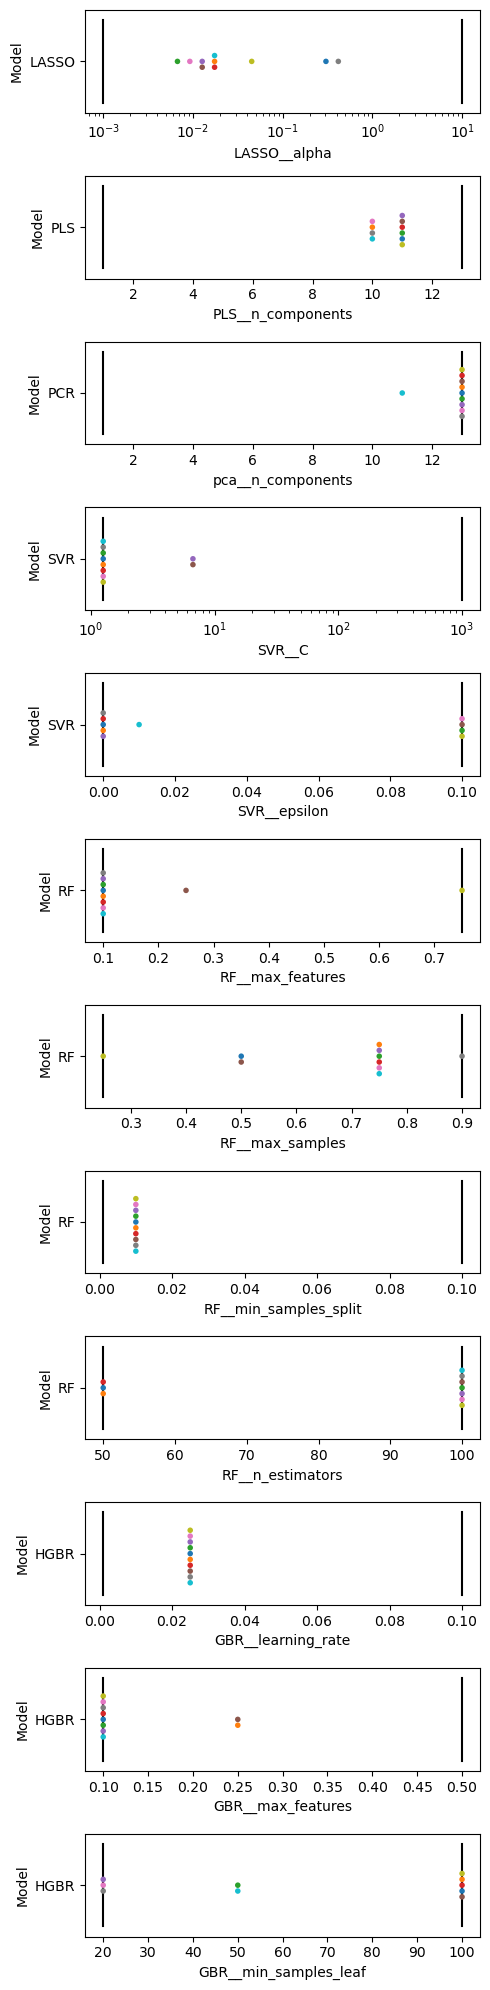

In [128]:
fig, axs = plt.subplots(nrows=len(param_dict.keys()), figsize=(5, 20))
for idx, k in enumerate(param_dict.keys()):
    ks = k.split('_')[0]
    if param_dict[k] in log_list:
        log_val = 10
    else:
        log_val = None
    sns.swarmplot(y='Model', x=param_dict[k], data=param_dfs[ks][param_dfs[ks]['Best'] == 1],
                  size=4,
                  hue='kfold',
                  orient='h',
                  legend=False,
                  ax=axs[idx],
                  log_scale=log_val
                 )
    axs[idx].axvline(x=param_dfs[ks][param_dict[k]].min(), ymin=0.1, ymax=0.9, color='black')
    axs[idx].axvline(x=param_dfs[ks][param_dict[k]].max(), ymin=0.1, ymax=0.9, color='black')
fig.tight_layout()

In [ ]:
sns.swarmplot(y='Model', x='LASSO__alpha', data=param_dfs['LASSO'][param_dfs['LASSO']['Best'] == 1],
              size=4,
              hue='kfold',
              orient='h',
              legend=False,
              ax=axs[0],
              log_scale=10
             )
axs[0].axvline(x=param_dfs['LASSO']['LASSO__alpha'].min(), ymin=0.1, ymax=0.9, color='black')
axs[0].axvline(x=param_dfs['LASSO']['LASSO__alpha'].max(), ymin=0.1, ymax=0.9, color='black')
#axs[0].set_xlim(-1, param_dfs['LASSO']['LASSO__alpha'].max()*1.2)


sns.swarmplot(y='Model', x='PLS__n_components', data=param_dfs['PLS'][param_dfs['PLS']['Best'] == 1],
              size=4,
              hue='kfold',
              orient='h',
              legend=False,
              ax=axs[1]
             )
axs[1].axvline(x=param_dfs['PLS']['PLS__n_components'].min(), ymin=0.1, ymax=0.9, color='black')
axs[1].axvline(x=param_dfs['PLS']['PLS__n_components'].max(), ymin=0.1, ymax=0.9, color='black')
#axs[0].set_xlim(-1, param_dfs['PLS']['PLS__n_components'].max()*1.2)

fig.tight_layout()

In [57]:
param_dfs['LASSO'][param_dfs['LASSO']['Best'] == 1]

,Model,kfold,Best,MAE,LASSO__alpha
18,LASSO,2014,1,-4.142827,0.30392
39,LASSO,2015,1,-4.169643,0.017433
66,LASSO,2016,1,-4.239205,0.006723
99,LASSO,2017,1,-4.245733,0.017433
128,LASSO,2018,1,-4.278226,0.01269
158,LASSO,2019,1,-4.205008,0.01269
187,LASSO,2020,1,-4.408323,0.009237
229,LASSO,2021,1,-4.251044,0.417532
252,LASSO,2022,1,-4.218210,0.045204
279,LASSO,2023,1,-4.176098,0.017433


## Plot parameter tuning

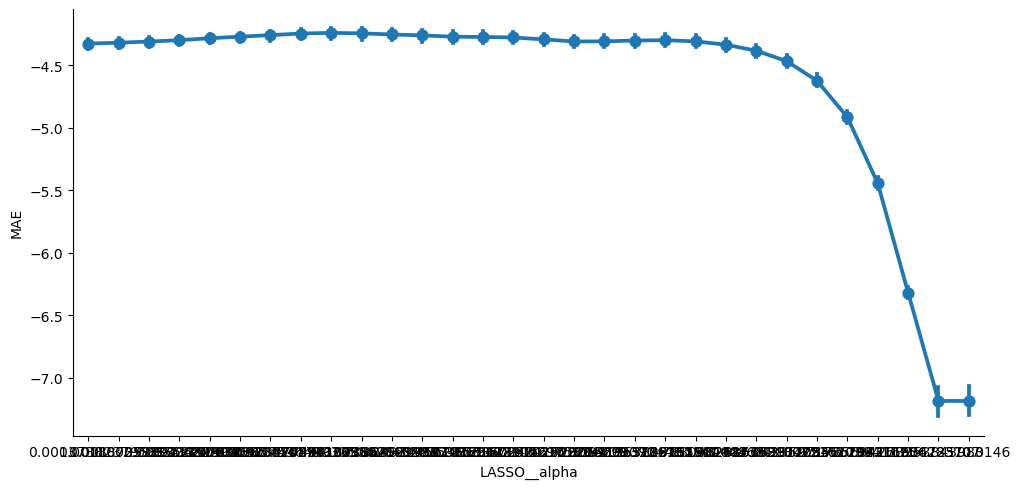

In [105]:
sns.catplot(x='LASSO__alpha', y='MAE', data=param_dfs['LASSO'], hue='kfold', kind='point', aspect=2)

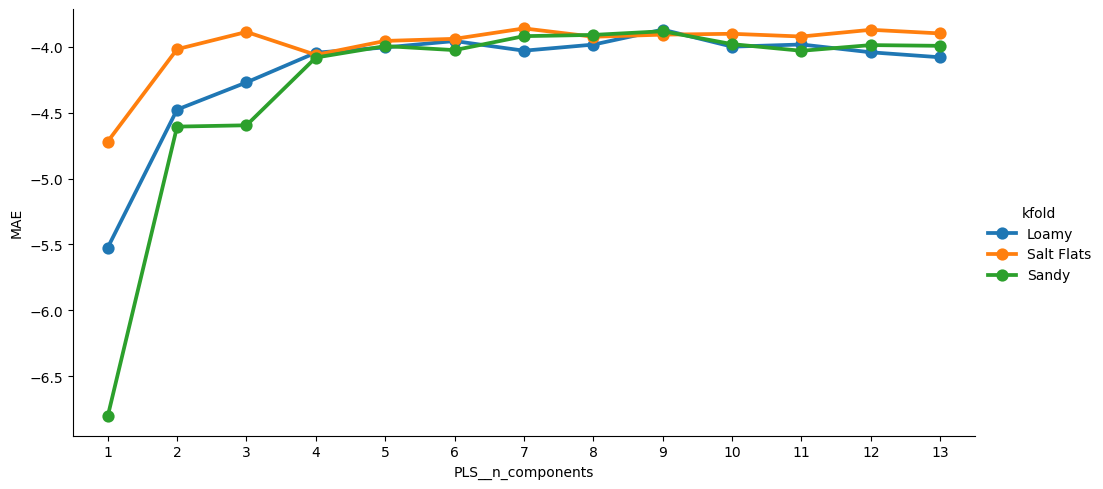

In [102]:
sns.catplot(x='PLS__n_components', y='MAE', data=param_dfs['PLS'], hue='kfold', kind='point', aspect=2)

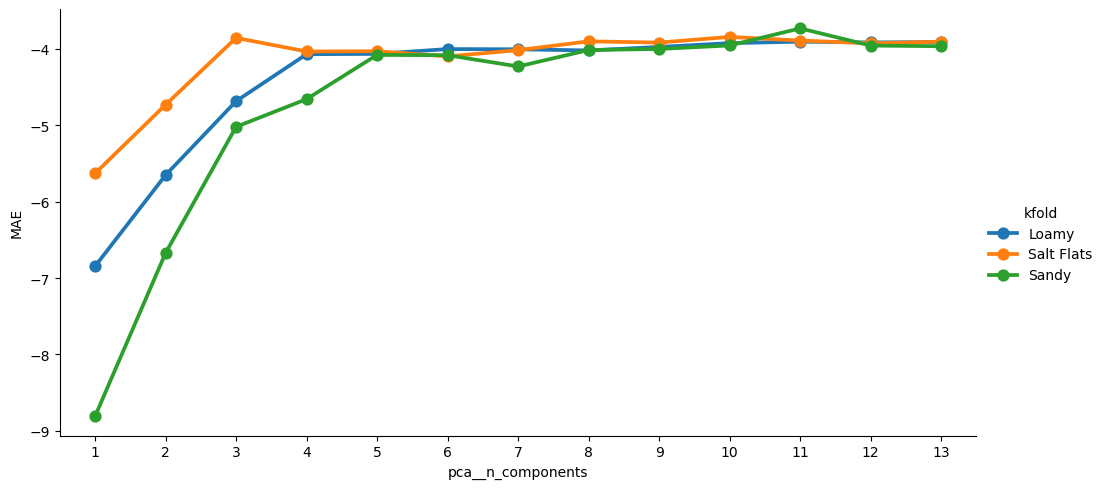

In [103]:
sns.catplot(x='pca__n_components', y='MAE', data=param_dfs['PCR'], hue='kfold', kind='point', aspect=2)

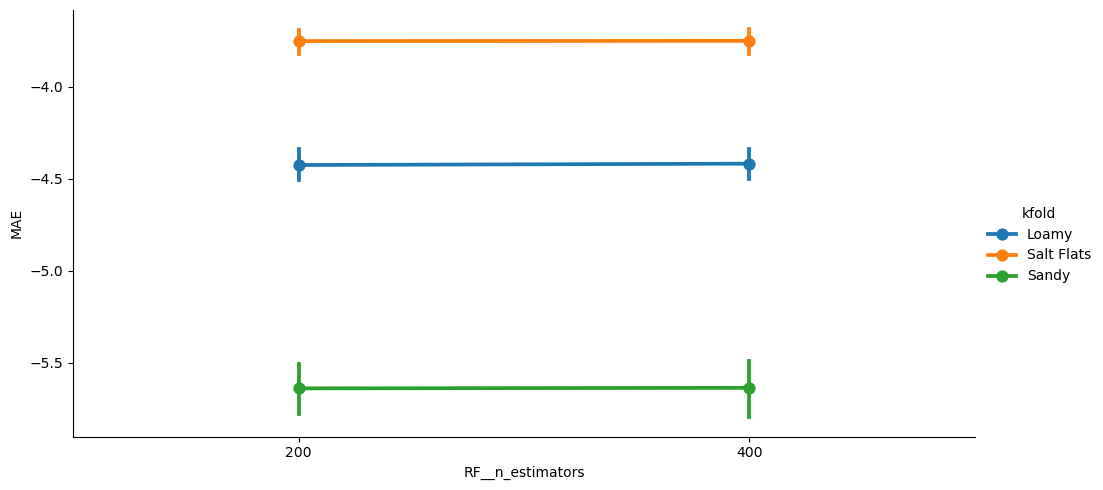

In [104]:
sns.catplot(x='RF__n_estimators', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

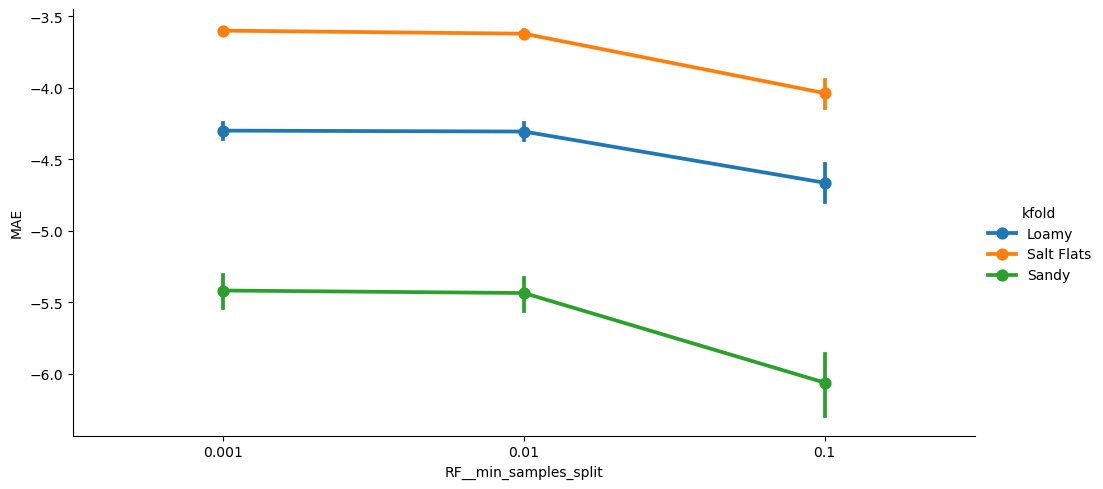

In [105]:
sns.catplot(x='RF__min_samples_split', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

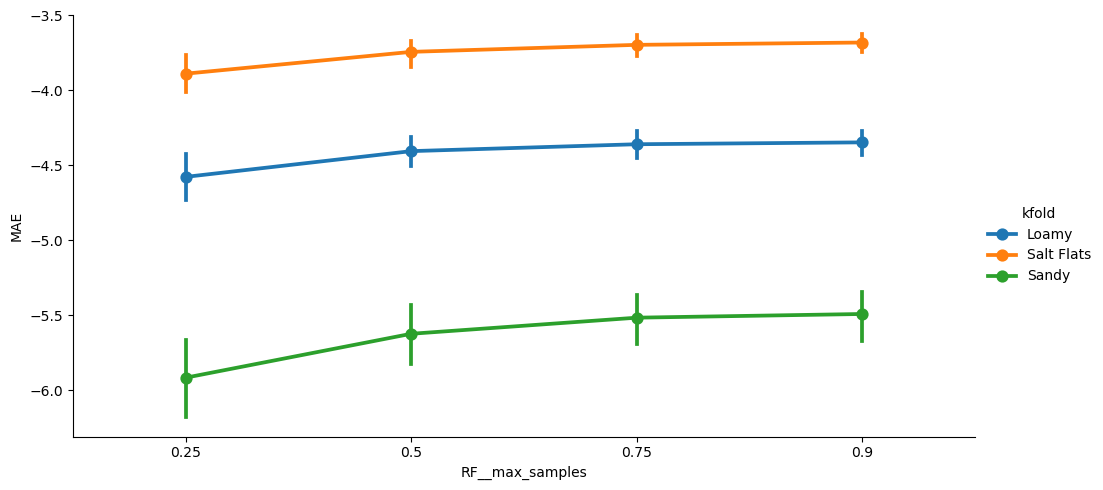

In [106]:
sns.catplot(x='RF__max_samples', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

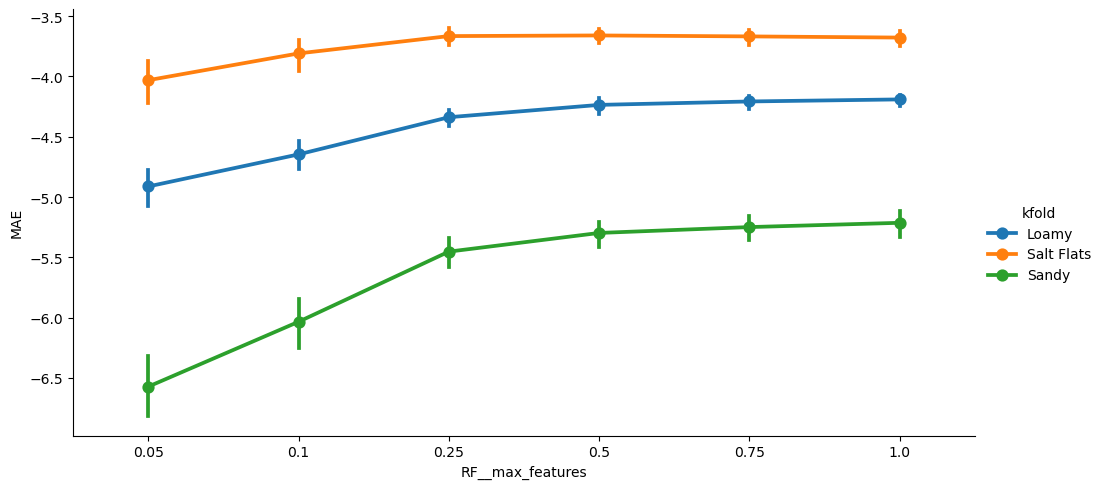

In [107]:
sns.catplot(x='RF__max_features', y='MAE', data=param_dfs['RF'], hue='kfold', kind='point', aspect=2)

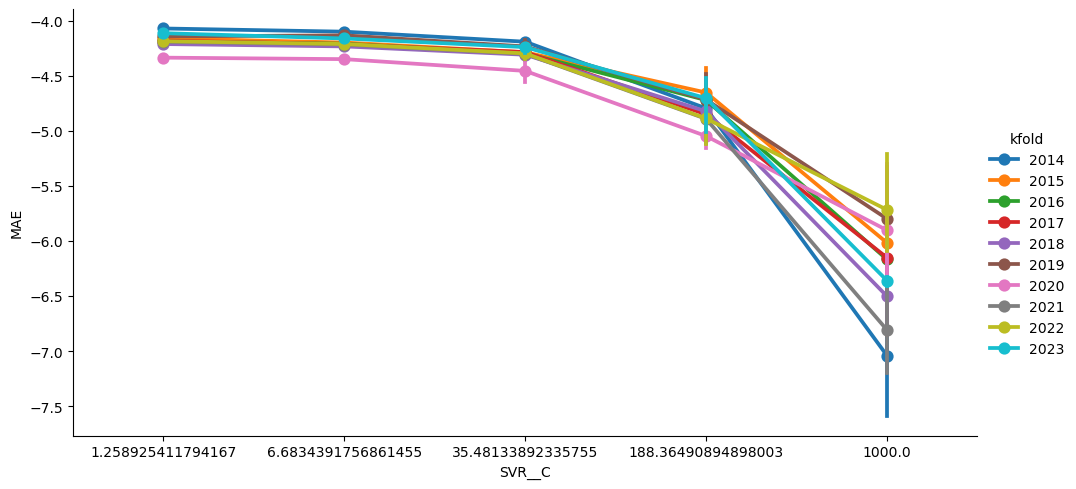

In [34]:
sns.catplot(x='SVR__C', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

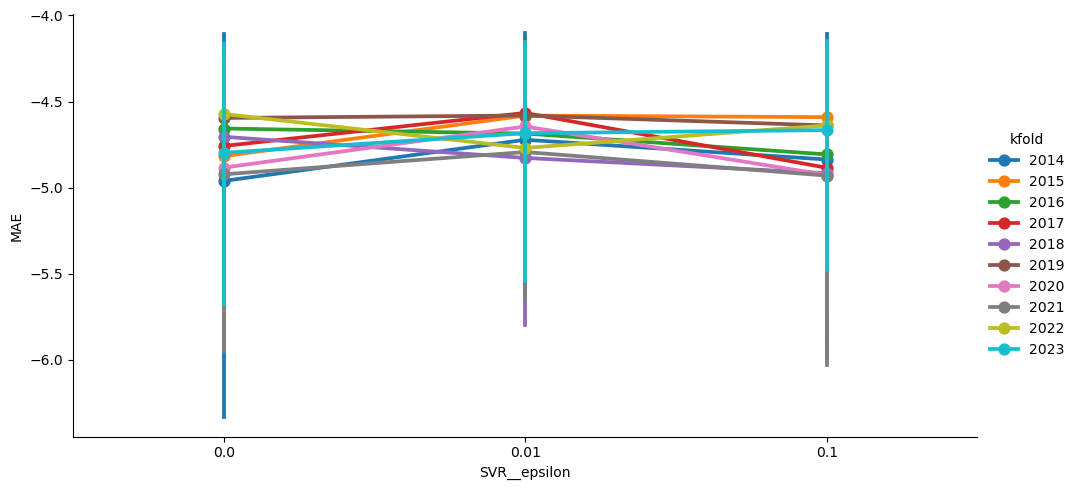

In [35]:
sns.catplot(x='SVR__epsilon', y='MAE', data=param_dfs['SVR'], hue='kfold', kind='point', aspect=2)

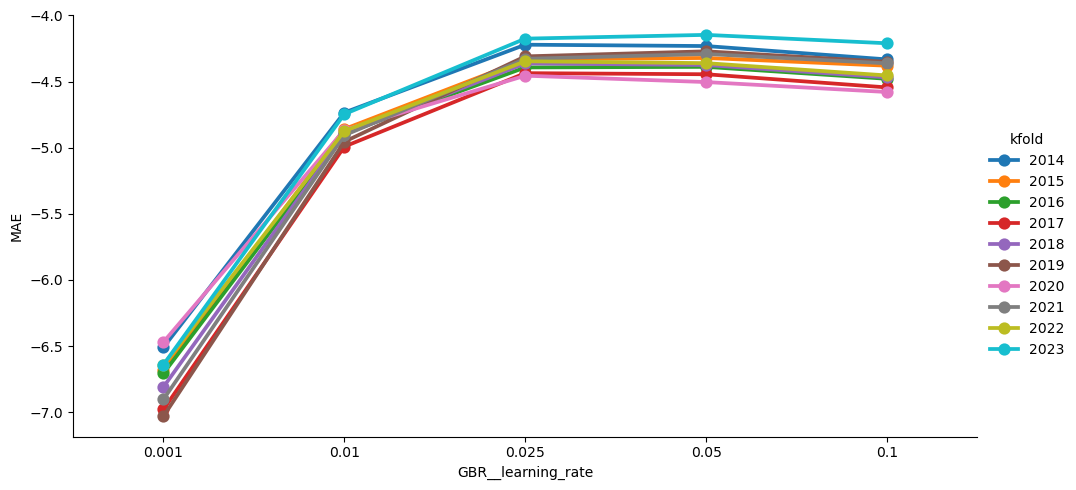

In [36]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

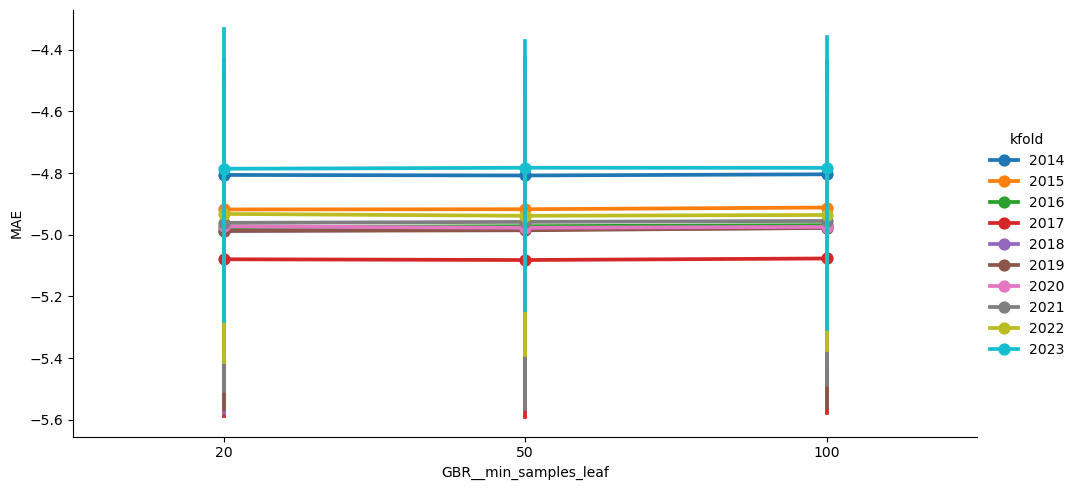

In [37]:
sns.catplot(x='GBR__min_samples_leaf', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

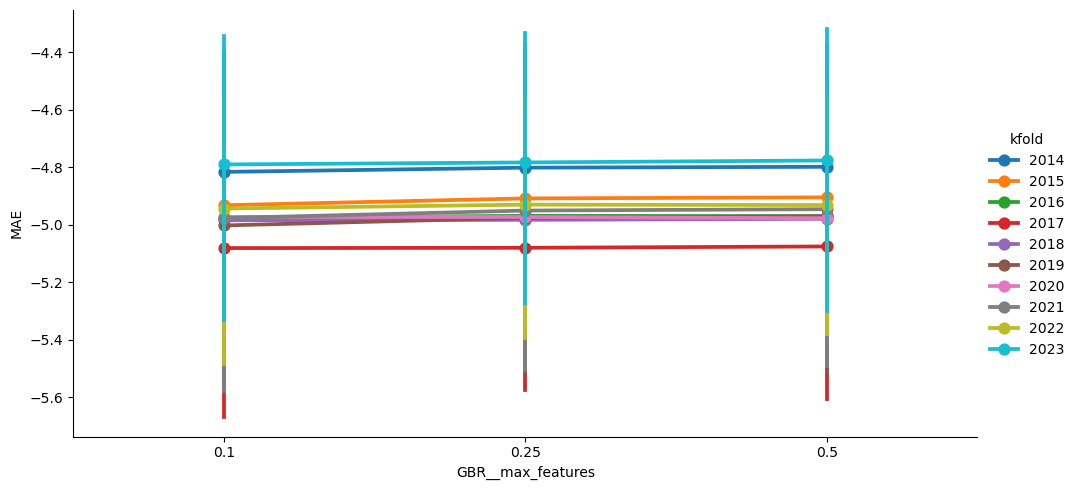

In [38]:
sns.catplot(x='GBR__max_features', y='MAE', data=param_dfs['HGBR'], hue='kfold', kind='point', aspect=2)

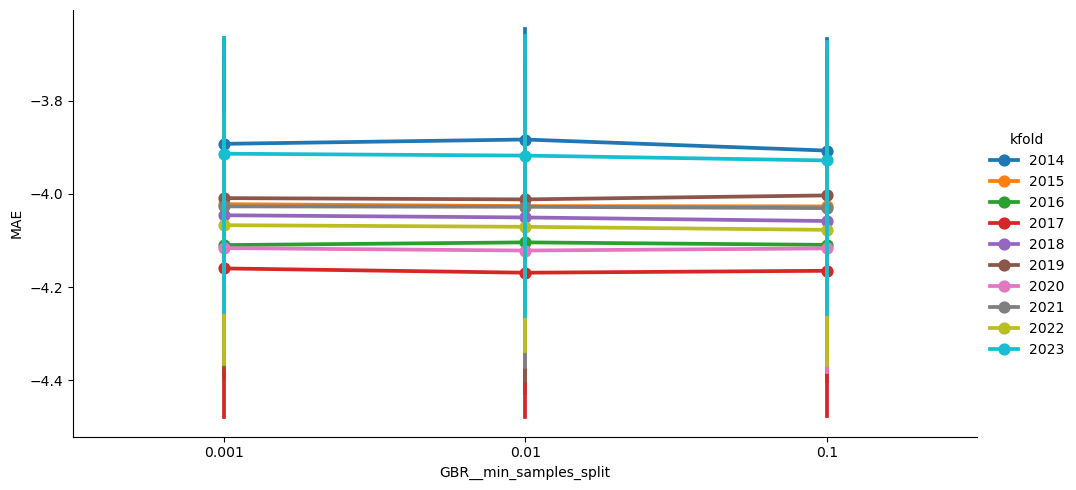

In [114]:
sns.catplot(x='GBR__min_samples_split', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

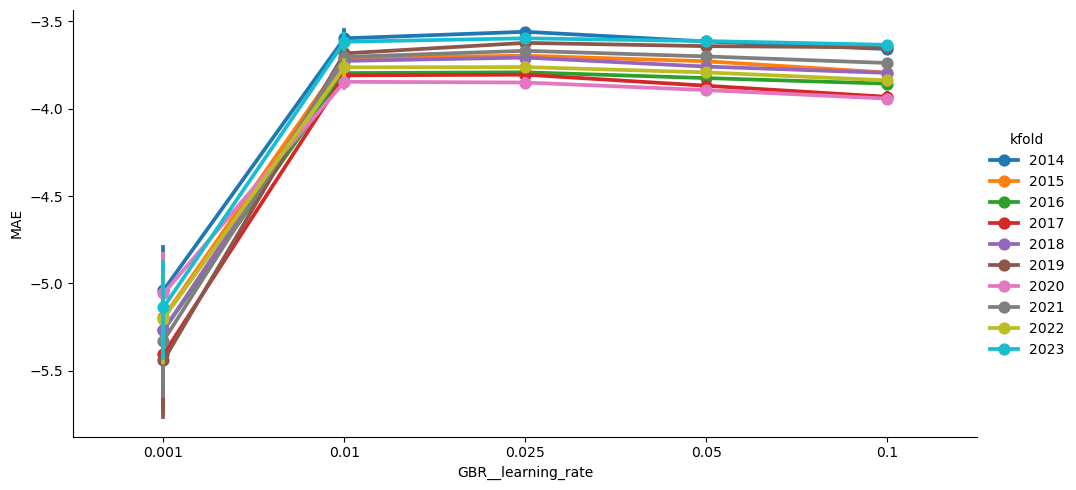

In [115]:
sns.catplot(x='GBR__learning_rate', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

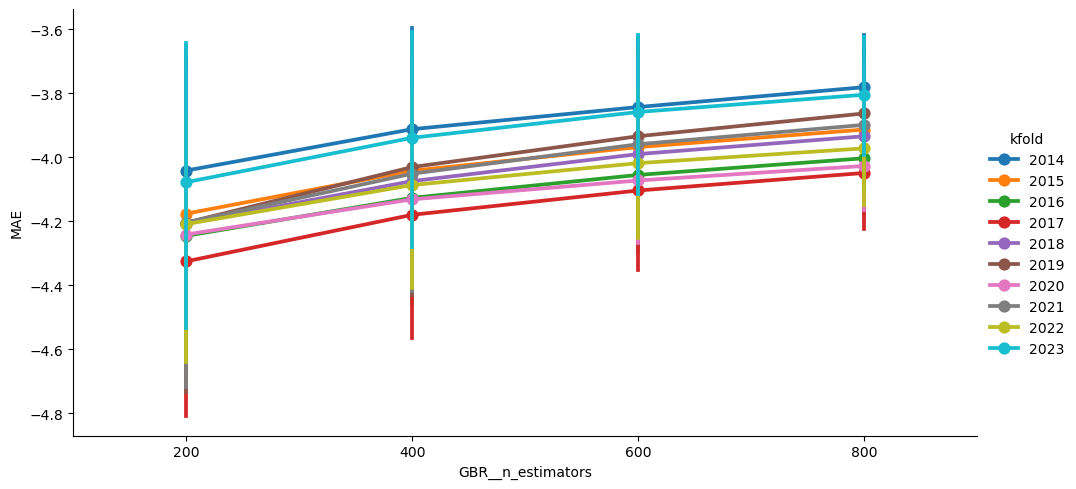

In [116]:
sns.catplot(x='GBR__n_estimators', y='MAE', data=param_dfs['GBR'], hue='kfold', kind='point', aspect=2)

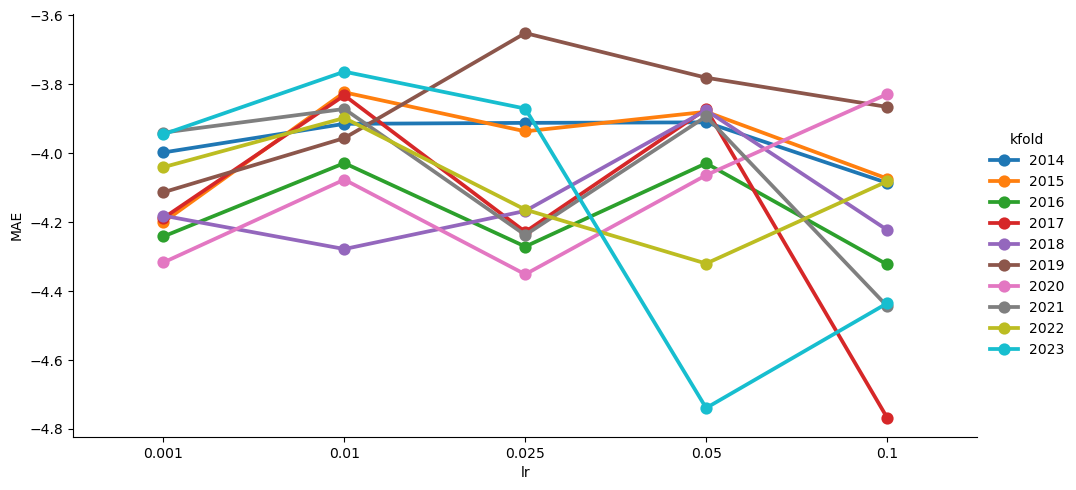

In [118]:
sns.catplot(x='lr', y='MAE', data=param_dfs['DNN'], hue='kfold', kind='point', aspect=2)